# Programación probabilista


In [1]:
#| code-fold: true

import arviz as az
import pymc as pm
import preliz as pz
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#| code-fold: true

az.style.use("arviz-doc")

Los objetivos de este capítulo son:

* Construir modelos con PyMC
* Analizar modelos con PyMC y ArviZ
* Explorar formas alternativas de interpretar la distribución _a posteriori_
* Discutir el tamaño del efecto sobre la significancia estadística 

La estadística Bayesiana es conceptualmente muy simple, tenemos lo _conocido_ y lo _desconocido_. El teorema de Bayes se utiliza para condicionar lo desconocido usando lo conocido, si tenemos suerte este proceso conducirá a una reducción de la incertidumbre sobre lo desconocido. Por lo general nos referimos a lo conocido como datos y los consideramos fijo mientras que lo desconocido toma la forma de parámetros de distribuciones de probabilidad. 








La simpleza conceptual para formular modelos Bayesianos contrasta con la dificultad matemático/computacional para resolverlos. Por muchos años esto fue un verdadero problema y retrasó la adopción de métodos Bayesianos.

A fin de poder resolver los modelos Bayesianos se recurre a métodos numéricos que pueden ser considerados como _motores universales de inferencia_. El hecho que tales motores sean posibles ha motivado el surgimiento de la programación probabilística, este tipo de lenguajes permiten una separación clara entre la creación de los modelos y el proceso de inferencia. 

Un lenguaje de programación probabilístico es, en lineas generales, un lenguaje que le permite al usuario describir, en una pocas lineas de código (las necesarias para describir el modelo), un modelo probabilístico completo. Luego se procede a utilizar este modelo para realizar la inferencia de forma automática. Se espera que la programación probabilística tenga un gran impacto en estadística, _machine learning_ y otras disciplinas al permitir que científicos construyan modelos complejos en menor tiempo y de forma menos propensa a errores.

Una buena analogía sobre el impacto que un lenguaje de programación puede tener en la ciencia es la introducción del lenguaje de programación Fortran hace más de 6 décadas. Fortran permitió a los científicos, por primera vez, abstraerse de muchos de los detalles computacionales y centrarse en la construcción de métodos numéricos, modelos y simulaciones de una manera más natural. De manera similar, se espera que los lenguajes de programación probabilísticos escondan del usuario detalles sobre cómo las probabilidades son manipuladas y cómo se lleva a cabo la inferencia, dejando que los usuarios se centren en la especificación del modelo y en el análisis e interpretación de los resultados.

## Introducción a PyMC

PyMC es un paquete para programación probabilística bajo Python. PyMC es lo suficientemente madura para resolver muchos problemas estadísticos.  PyMC permite crear modelos probabilísticos usando una sintaxis intuitiva y fácil de leer que es muy similar a la sintaxis usada para describir modelos probabilísticos.

La mayoría de las funciones de PyMC están escritas en Python. Mientras que las partes computacionalmente demandantes están escritas en NumPy y [PyTensor](https://pytensor.readthedocs.io/en/latest/). Pytensor es una biblioteca de Python que permite definir, optimizar y evaluar expresiones matemáticas que involucran matrices multidimensionales de manera eficiente. PyTensor es hija de Theano una librería de Python originalmente desarrollada para _deep learning_ (que es a su vez la antecesora de TensorFlow, PyTorch, etc).

### El problema de la moneda, ahora  usando PyMC y ArviZ

A continuación revistaremos el problema de la moneda visto en el capítulo anterior, usando esta vez PyMC para definir nuestro modelo y hacer inferencia. Luego usaremos ArviZ para analizar el _a posterori_. 

A continuación generaremos datos sintéticos, en este caso asumiremos que conocemos el valor the $\theta$ y lo llamaremos `theta_real`, y luego intentaremos _averiguar_ este valor _como si no_ lo conociéramos. En un problema _real_ `theta_real` sería desconocido y realizaríamos un proceso de inferencia precisamente para averiguar su valor.

In [3]:
n_experimentos = 4
theta_real = 0.35  # en una situación real este valor es desconocido
datos = pz.Binomial(n=1, p=theta_real).rvs(size=n_experimentos, random_state=123)
datos

array([1, 0, 0, 0], dtype=int64)

### Creación del modelo

Ahora que tenemos nuestros datos es necesario especificar el modelo. Para ello usaremos una distribución beta (con parámetros $\alpha=\beta=1$) como _a priori_ y la distribución de Bernoulli como likelihood. Usando la notación usual en estadística tenemos:

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha=1, \beta=1)\\
Y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

> Cada uno de los elementos del _array_ `datos` es un experimento de Bernoulli, es decir un experimento donde solo es posible obtener dos valores (0 o 1) si en cambio tuviera el número total de "caras" obtenidas en varios experimentos de Bernoulli podríamos modelar el likelihood como una distribución Binomial. 

Esto modelo se traduce casi literalmente a PyMC, veamos:

In [4]:
with pm.Model() as nuestro_primer_modelo:
    θ = pm.Beta("θ", alpha=1, beta=1)  # a priori
    y = pm.Bernoulli("y", p=θ, observed=datos)  # likelihood
    # y = pm.Binomial('y',n=n_experimentos, p=θ, observed=sum(datos))

En la primer linea hemos creado un nuevo objeto llamado *nuestro_primer_modelo*. Este objeto contiene información sobre el modelo y las variables que lo conforman. PyMC usa el bloque _with_ para indicar que todas las lineas que están dentro de él hacen referencia al mismo modelo (que en este caso se llama *nuestro_primer_modelo*).

La segunda linea de código, especifica el _a priori_, como pueden ver la sintaxis sigue de cerca a la notación matemática, la única diferencia es que el primer argumento es siempre una _cadena_ que especifica el nombre de la variable aleatoria (el nombre es usado internamente por PyMC), este nombre siempre deberá coincidir con el nombre de la variable de Python a la que se le asigna. De no ser así el código correrá igual, pero puede conducir a errores y confusiones al analizar el modelo.

 >Es importante recalcar que las variables de PyMC, como $\theta$, no son números sino objetos que representan distribuciones. Es decir objetos a partir de los cuales es posible calcular probabilidades y generar números aleatorios.

En la tercer linea de código se especifica el _likelihood_, que como verán es similar a la linea anterior con la diferencia que hemos agregado un argumento llamado `observed` al cual le asignamos nuestros datos. Esta es la forma de indicarle a PyMC cuales son los datos. Los datos pueden ser números, listas de Python, *arrays* de NumPy o *data_frames* de Pandas.

### Inferencia

Nuestro modelo ya está completamente especificado, lo único que nos resta hacer es obtener el _a posteriori_. En el capítulo anterior vimos como hacerlo de forma analítica, ahora lo haremos con métodos numéricos. 

En PyMC la inferencia se realiza escribiendo las siguientes lineas:

In [5]:
with nuestro_primer_modelo:
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Primero llamamos al objeto que definimos como nuestro modelo (*nuestro_primer_modelo*), indicando de esta forma que es sobre ese objeto que queremos realizar la inferencia. En la segunda linea le indicamos a PyMC que deseamos 1000 muestras. Esta linea luce inocente, pero internamente PyMC está haciendo muchas cosas por nosotros. Algunas de las cuales son detalladas en el mensaje que se imprime en pantalla.

Veamos este mensaje:

* La primer linea indica que PyMC ha asignado el método de muestreo NUTS, el cual es un muy buen método para variables continuas.
* La segunda linea nos da información sobre cómo se inicializaron los valores de NUTS. Un detalle que por ahora no nos preocupa.
* La tercer linea indica que PyMC correrá cuatro cadenas en paralelo, es decir generará cuatro muestras independientes del _a posteriori_. Esta cantidad puede ser diferente en sus computadoras ya que es determinada automáticamente en función de los procesadores disponibles (que en mi caso, 4). `sample` tiene un argumento `chains` que permite modificar este comportamiento.
* La cuarta linea indica qué variable ha sido asignada a cual método de muestreo. En este caso la información es redundante, ya que tenemos una sola variable, pero esto no siempre es así. PyMC permite combinar métodos de muestreo, ya sea de forma automática basado en propiedades de las variables a muestrear o especificado por el usuario usando el argumento `step`. 
* La quinta linea es una barra de progreso con varias métricas sobre la velocidad del muestreo, que en este caso (y para referencia futura) es muy alta. También indica la cantidad de cadenas usadas y la cantidad de divergencias. Tener 0 divergencias es ideal, más adelante discutiremos la razón.
* Por último tenemos un detalle de la cantidad de muestras generadas, aunque pedimos 1000 obtuvimos 8000, la razón es que es son 1000 por cadena (4 cadenas en mi caso), es decir 4000. Todavía nos queda explicar 4000 muestras _extras_, estas se corresponden a 1000 por cadena y son muestras que PyMC utiliza para _auto-tunear_ el método de muestreo. Estás muestras son luego descartadas automáticamente ya que no son muestras representativas del posterior. La cantidad de pasos que se usan para _tunear_  el algoritmo de muestreo se puede cambiar con el argumento `tune` de la función `pm.sample(.)`.

### Resumiendo el  _a posteriori_

Por lo general, la primer tarea a realizar luego de haber realizado un muestreo es evaluar como lucen los resultados. La función `plot_forestplot` de ArviZ es muy útil para esta tarea.

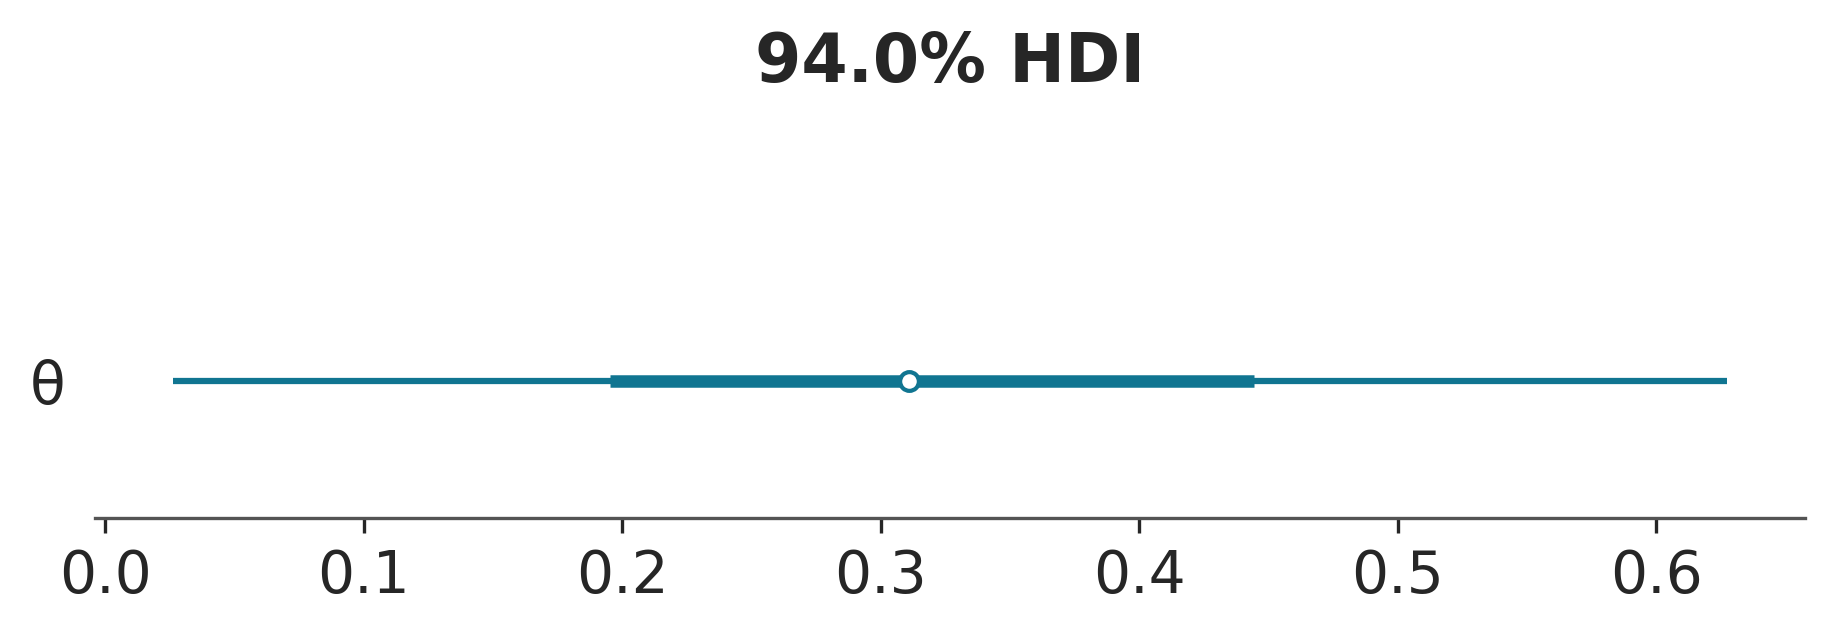

In [6]:
az.plot_forest(idata, combined=True, figsize=(6, 2));

El punto indica la media, la linea gruesa el rango intercuartil y las lineas finas el HDI 94%

> Es importante notar que la variable `y` es una variable observada, es decir conocida. Mientras que en el gráfico anterior estamos dibujando solo $\theta$ que es la única variables desconocida, y por lo tanto muestreada.

Si quisiéramos un resumen numérico de los resultados podemos usar:

In [7]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
θ,0.329,0.172,0.026,0.627


Como resultado obtenemos un DataFrame con los valores de la media, la desviación estándar y el intervalo HDI 94% (hdi_3  hdi_97).

Otra forma de resumir visualmente el a posteriori es usar la función `plot_posterior` que viene con ArviZ, ya hemos utilizado esta distribución en el capítulo anterior para un falso a posteriori. Vamos a usarlo ahora con un posterior real. Por defecto, esta función muestra un histograma para variables discretas y KDEs para variables continuas. También obtenemos la media de la distribución (podemos preguntar por la mediana o moda usando el argumento `point_estimate`) y el 94% HDI como una línea negra en la parte inferior de la gráfica. Se pueden establecer diferentes valores de intervalo para el HDI con el argumento `hdi_prob`. Este tipo de gráfica fue presentado por John K. Kruschke en su gran libro "Doing Bayesian Data Analysis".

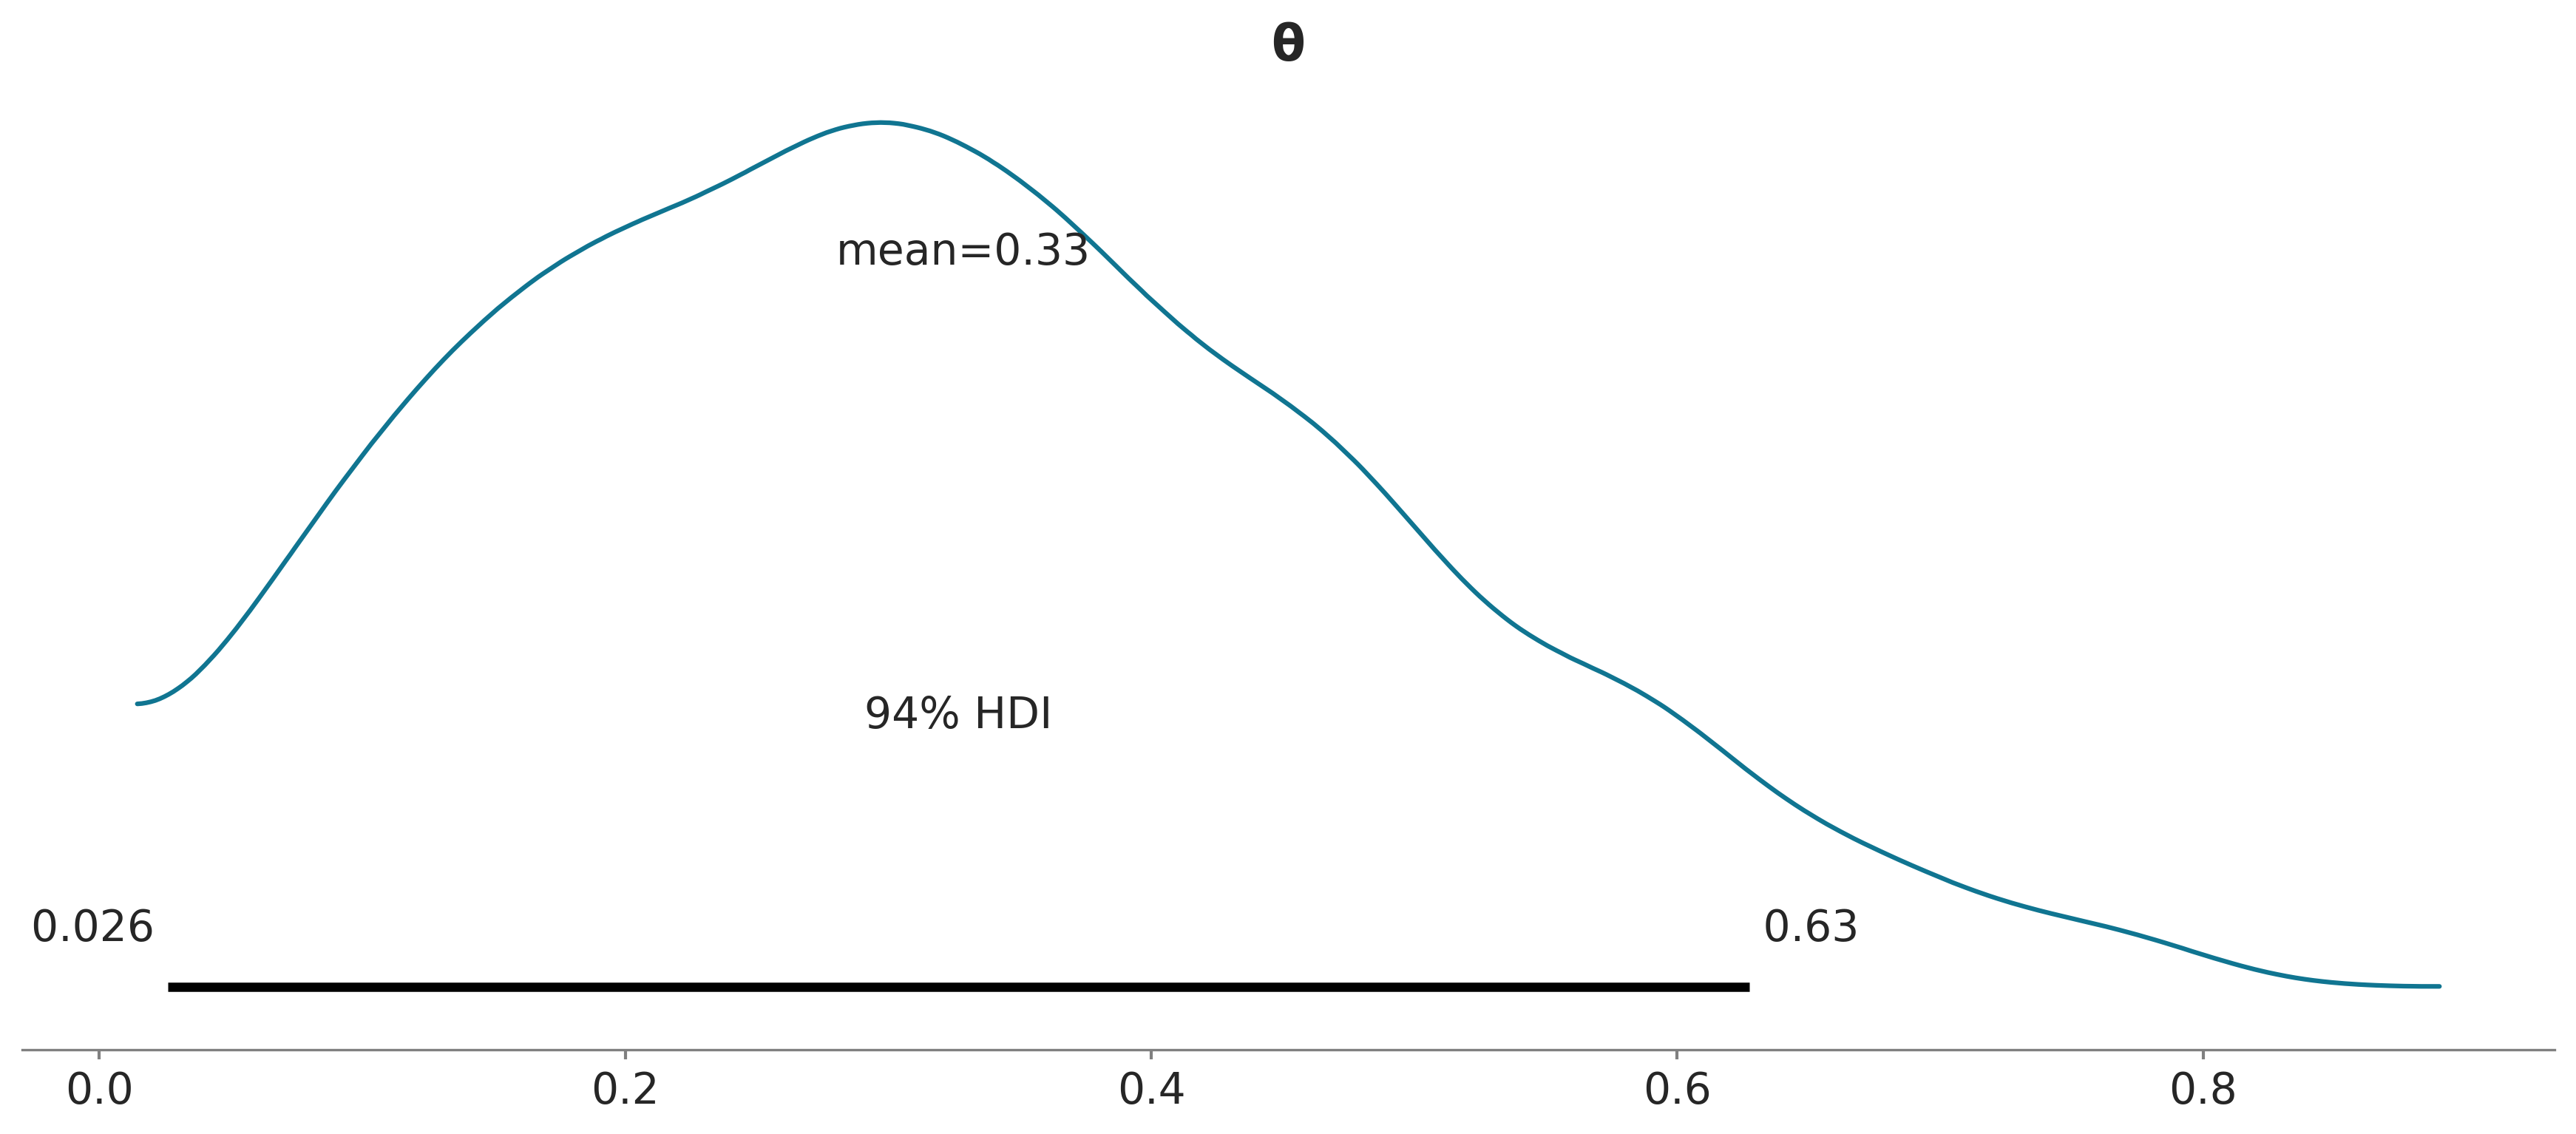

In [8]:
az.plot_posterior(idata);

### Accidentes mineros

Este ejemplo está tomado del [tutorial](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html#case-study-2-coal-mining-disasters) de PyMC. 

El problema es el siguiente, tenemos un registro del número de accidentes en minas de carbón, ubicadas en el Reino Unido, que ocurrieron entre 1851 y 1962 ([Jarrett, 1979](http://biomet.oxfordjournals.org/content/66/1/191.abstract)). Se sospecha que la aplicación de ciertas regulaciones de seguridad tuvo como efecto una disminución en la cantidad de catástrofes. Por lo tanto nos interesa averiguar el año en que la tasa cambió y nos interesa estimar ambas tasas. 

Los datos son los siguientes, por un lado tenemos la variable _accidentes_ que contiene la cantidad de accidentes por año y por el otro la variable _años_ conteniendo el rango de años para los cuales tenemos datos. `accidentes` es una serie de Pandas que contiene el valor especial `NAN`, este es el valor por defecto en Pandas para lidiar con datos faltantes.

Bien, pero para que molestarse con datos faltantes si en general es más fácil eliminarlos. una de las razones es que esto puede conducir a pérdida de información cuando por cada observación tenemos más de una variable o cantidad de interés. Por ejemplo si tenemos 50 sujetos a los que les hemos medido la presión, la temperatura y el ritmo cardíaco, pero sucede que para 4 de ellos no contamos con el datos de la presión (porque alguien se olvidó de medirlo o registrarlo, o porque el tensiómetro se rompió, o por lo que sea). Podemos eliminar esos cuatro sujetos del análisis y perder por lo tanto información sobre la presión y ritmo cardíaco, o podemos usar todos los datos disponibles y además estimar los valores de temperatura faltantes. En el contexto de la estadística Bayesiana los datos faltantes se tratan como un parámetro desconocido del modelo que puede ser estimado.

In [9]:
accidentes = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                       3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                       2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                       1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                       0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                       3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
años = np.arange(1851, 1962)

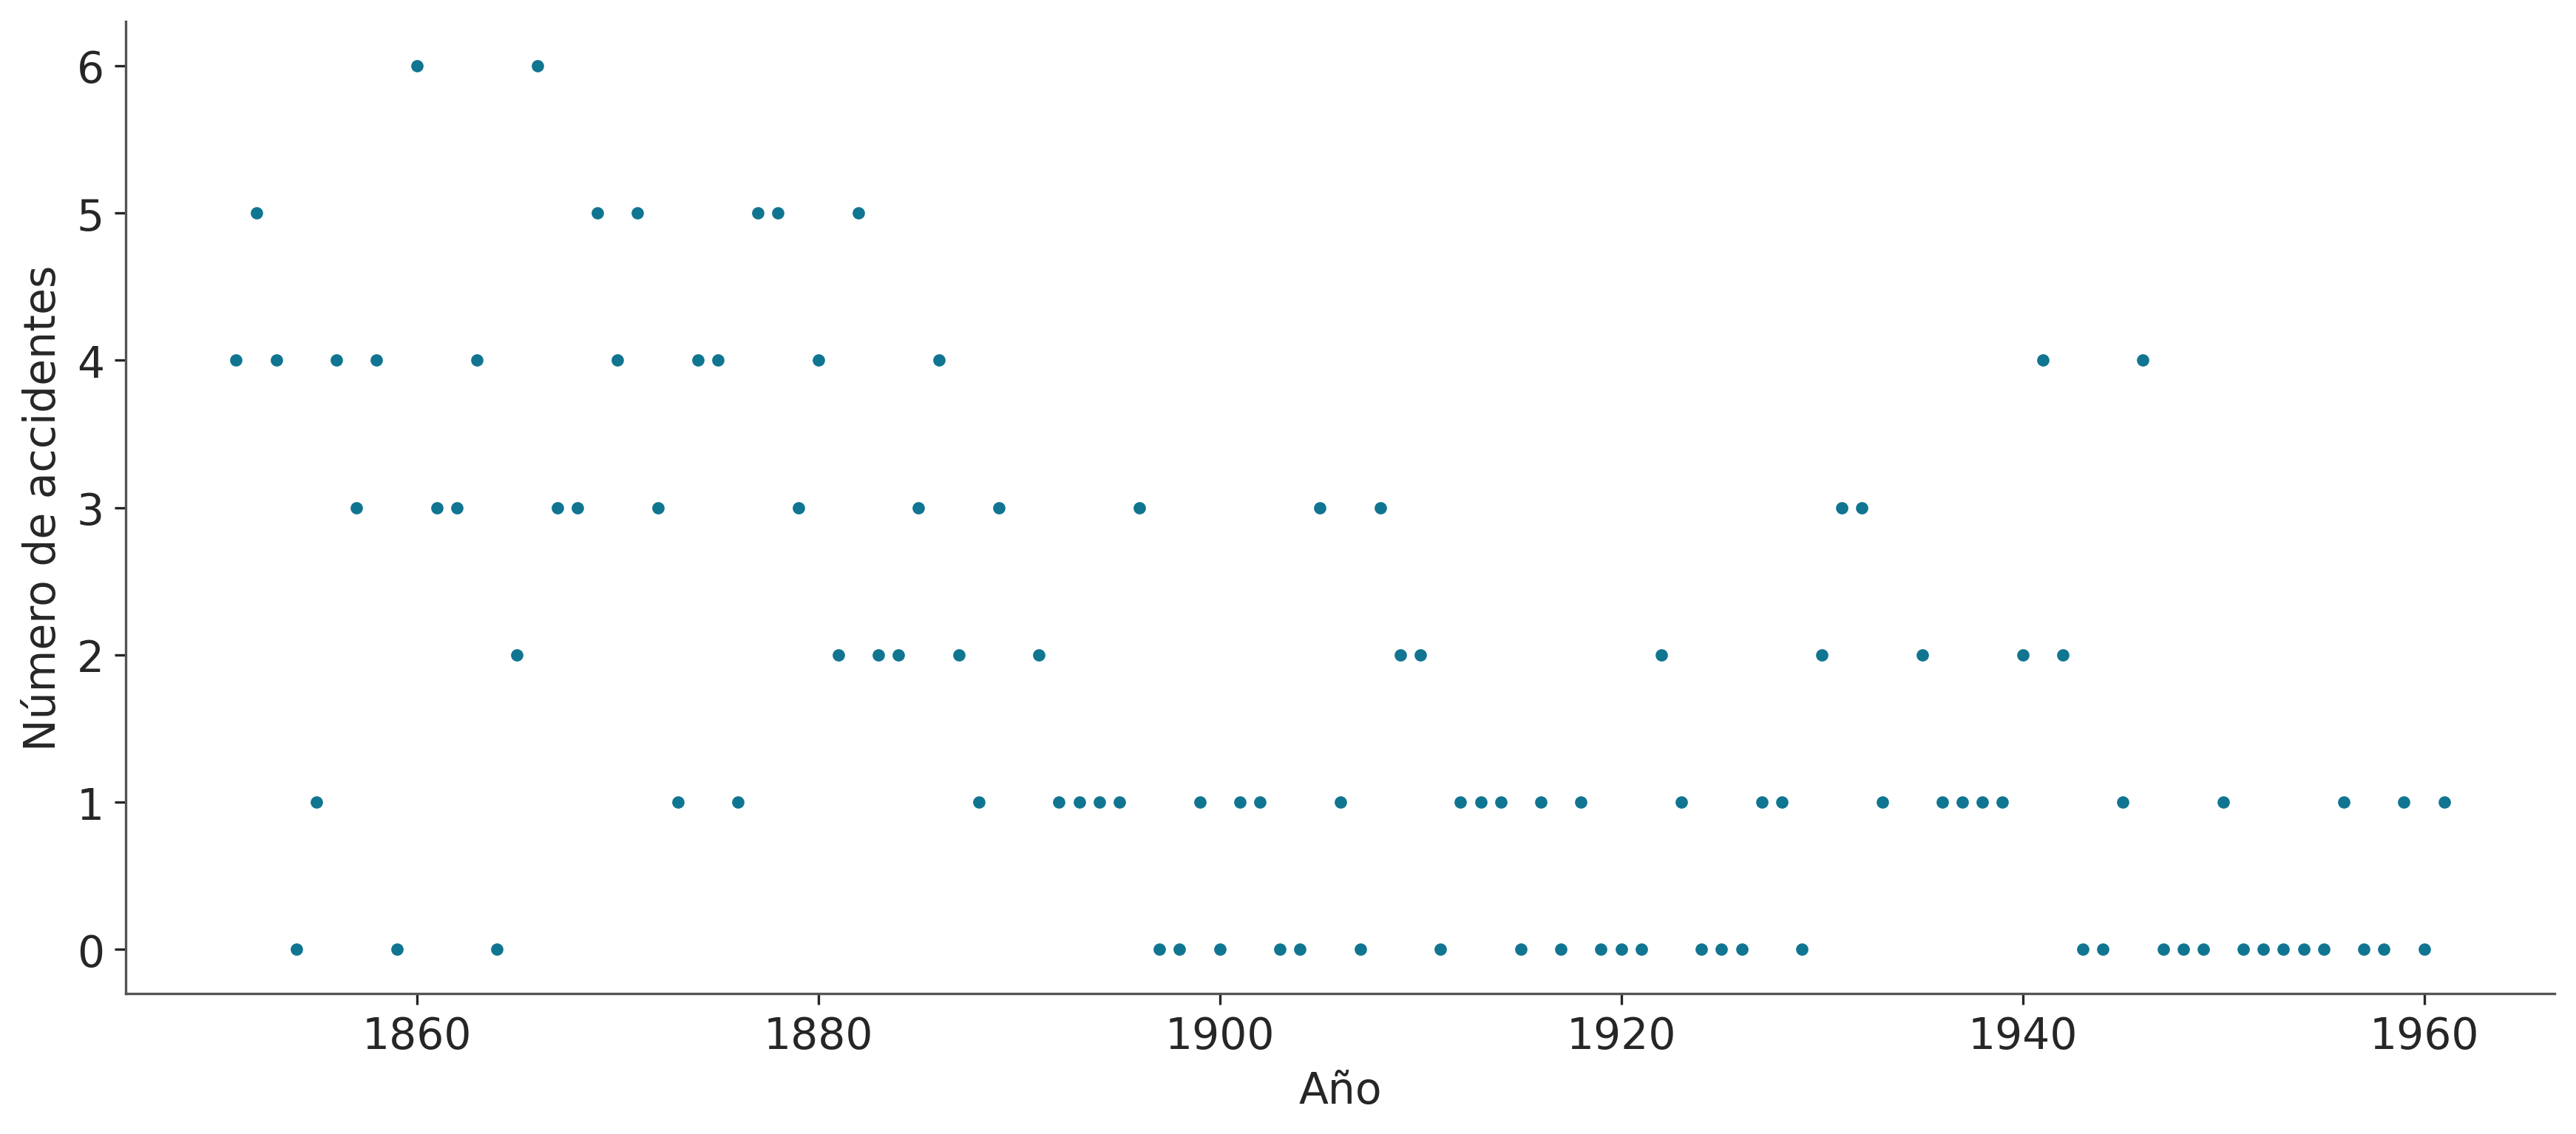

In [10]:
plt.plot(años, accidentes, ".")
plt.ylabel("Número de accidentes")
plt.xlabel("Año");

Para modelar los accidentes usaremos una distribución de Poisson. Como creemos que la cantidad media de accidentes es distinta antes y después de la introducción de regulaciones de seguridad usaremos dos valores de tasas medias de accidentes ($t_0$ y $t_1$). Además deberemos estimar un punto de corte ($pc$) que dividirá los años para los cuales se aplica la tasa de accidentes $t_0$ de los cuales se aplica la tasa $t_1$:

\begin{equation}
A_t \sim Poisson(tasa)
\end{equation}

\begin{equation}
tasa = \begin{cases}
t_0, \text{si } t \ge pc,\\
t_1, \text{si } t \lt pc
\end{cases}
\end{equation}

Los _a prioris_ que usaremos serán:

\begin{align}
t_0 \sim Expon(1) \\
t_1 \sim Expon(1) \\
pc \sim U(A_0, A_1)
\end{align}

Donde la distribución uniforme es discreta y $A_0$ y $A_1$ corresponden al primer y último año considerado en el análisis respectivamente.


Gráficamente el modelo es:

<center>
<img src="img/modelo_mineros.png" width=350>
</center>


Una peculiaridad de la implementación de este modelo en PyMC es el uso de la función `pm.switch` (linea 10). Esta es en realidad una función de PyMC y equivale a un _if else_ de Python. Si el primer argumento es _True_ entonces devuelve el segundo argumento caso contrario el tercer argumento. Como resultado tenemos que _tasa_ es un vector de longitud igual a la de _años_ y cuyos elementos corresponden a una repetición $t_0$ seguida de una repetición $t_1$, la cantidad exacta de repeticiones de $t_0$ y $t_1$ está controlada por la condición $pc \ge$ _años_. De esta forma, podemos al muestrear $pc$, modificar que años reciben cual tasa para el cálculo del _likelihood_.

In [11]:
with pm.Model() as modelo_cat:

    pc = pm.DiscreteUniform("pc", lower=años.min(), upper=años.max())

    # Priors para las tasas antes y después del cambio.
    t_0 = pm.Exponential("t_0", 1)
    t_1 = pm.Exponential("t_1", 1)

    # Asignamos las tasas a los años de acuerdo a pc
    tasa = pm.Deterministic("tasa", pm.math.switch(pc >= años, t_0, t_1))

    acc = pm.Poisson("acc", tasa, observed=accidentes)
    idata_cat = pm.sample(1000, random_seed=1791, idata_kwargs={"log_likelihood": True})

c:\Users\admin\Desktop\unsam\Ciencia_de_Datos\Estadistica e Inferencia 2\estadistica_e_inferencia_II\.venv\Lib\site-packages\pymc\model\core.py:1342: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
c:\Users\admin\Desktop\unsam\Ciencia_de_Datos\Estadistica e Inferencia 2\estadistica_e_inferencia_II\.venv\Lib\site-packages\pymc\model\core.py:1356: ImputationWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [pc]
>>Metropolis: [acc_unobserved]
>NUTS: [t_0, t_1]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 139 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
idata_cat

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

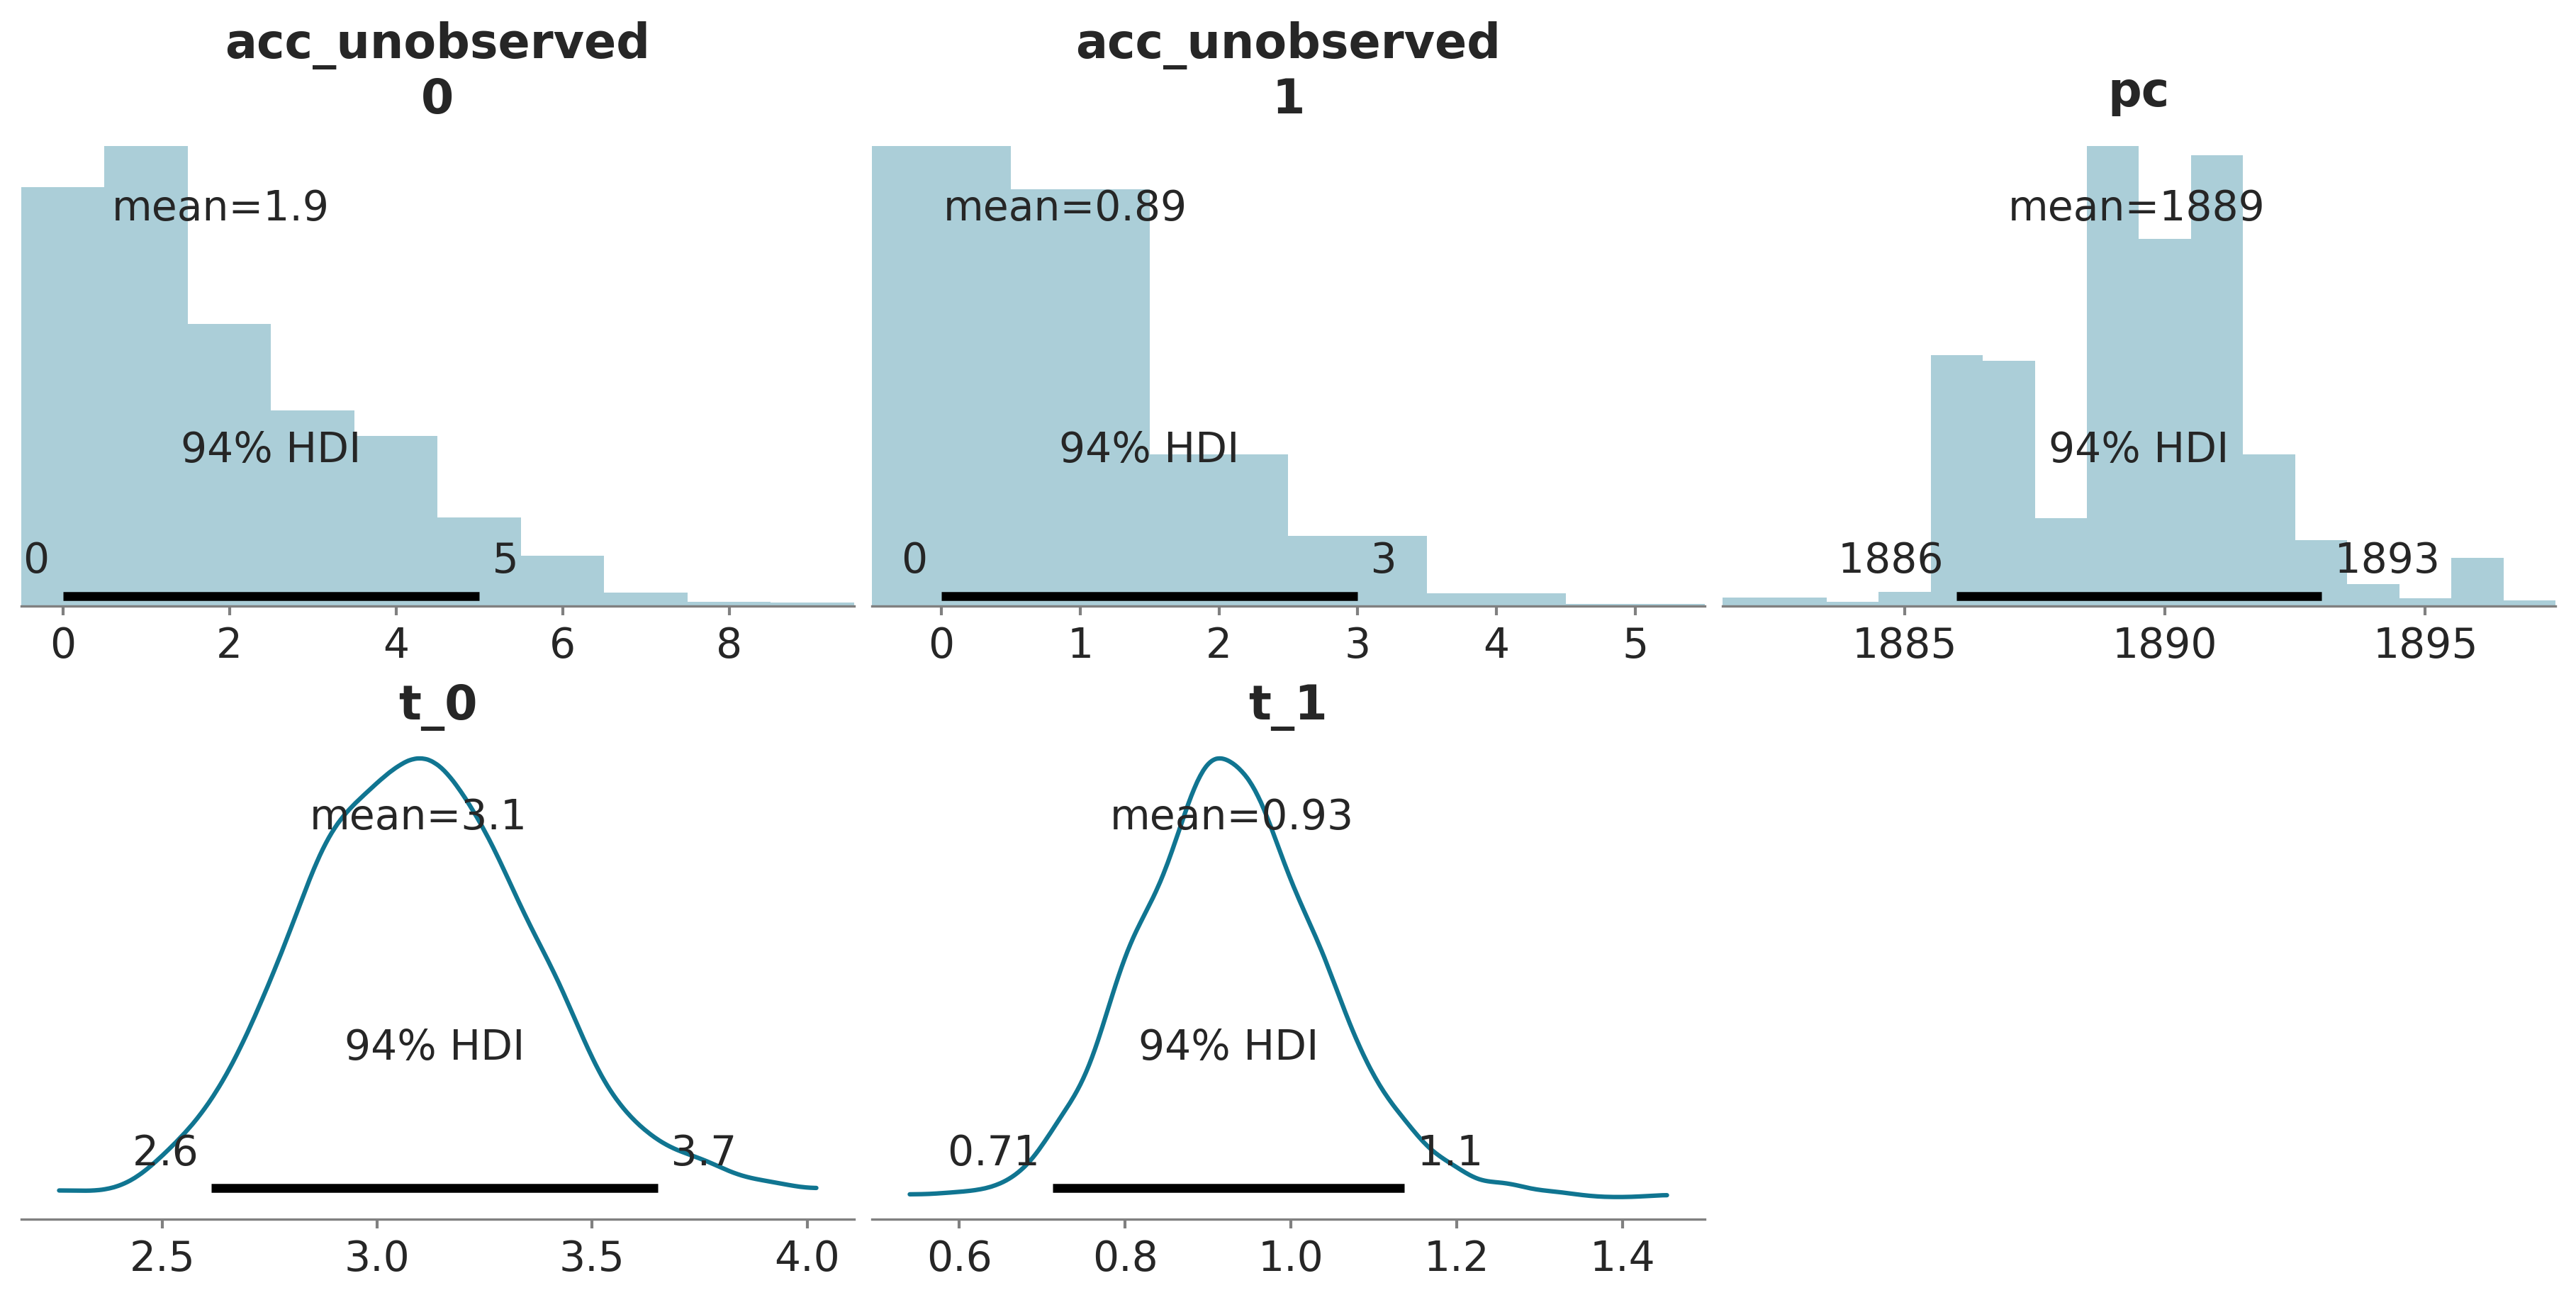

In [13]:
ax = az.plot_posterior(idata_cat, var_names=["~tasa", "~acc"], figsize=(12, 6));

In [14]:
az.summary(idata_cat, kind="stats", var_names=["~tasa", "~acc"])

,mean,sd,hdi_3%,hdi_97%
acc_unobserved[0],1.895,1.766,0.000,5.000
acc_unobserved[1],0.892,0.962,0.000,3.000
pc,1889.456,2.346,1886.000,1893.000
t_0,3.096,0.275,2.614,3.652
t_1,0.929,0.114,0.713,1.136


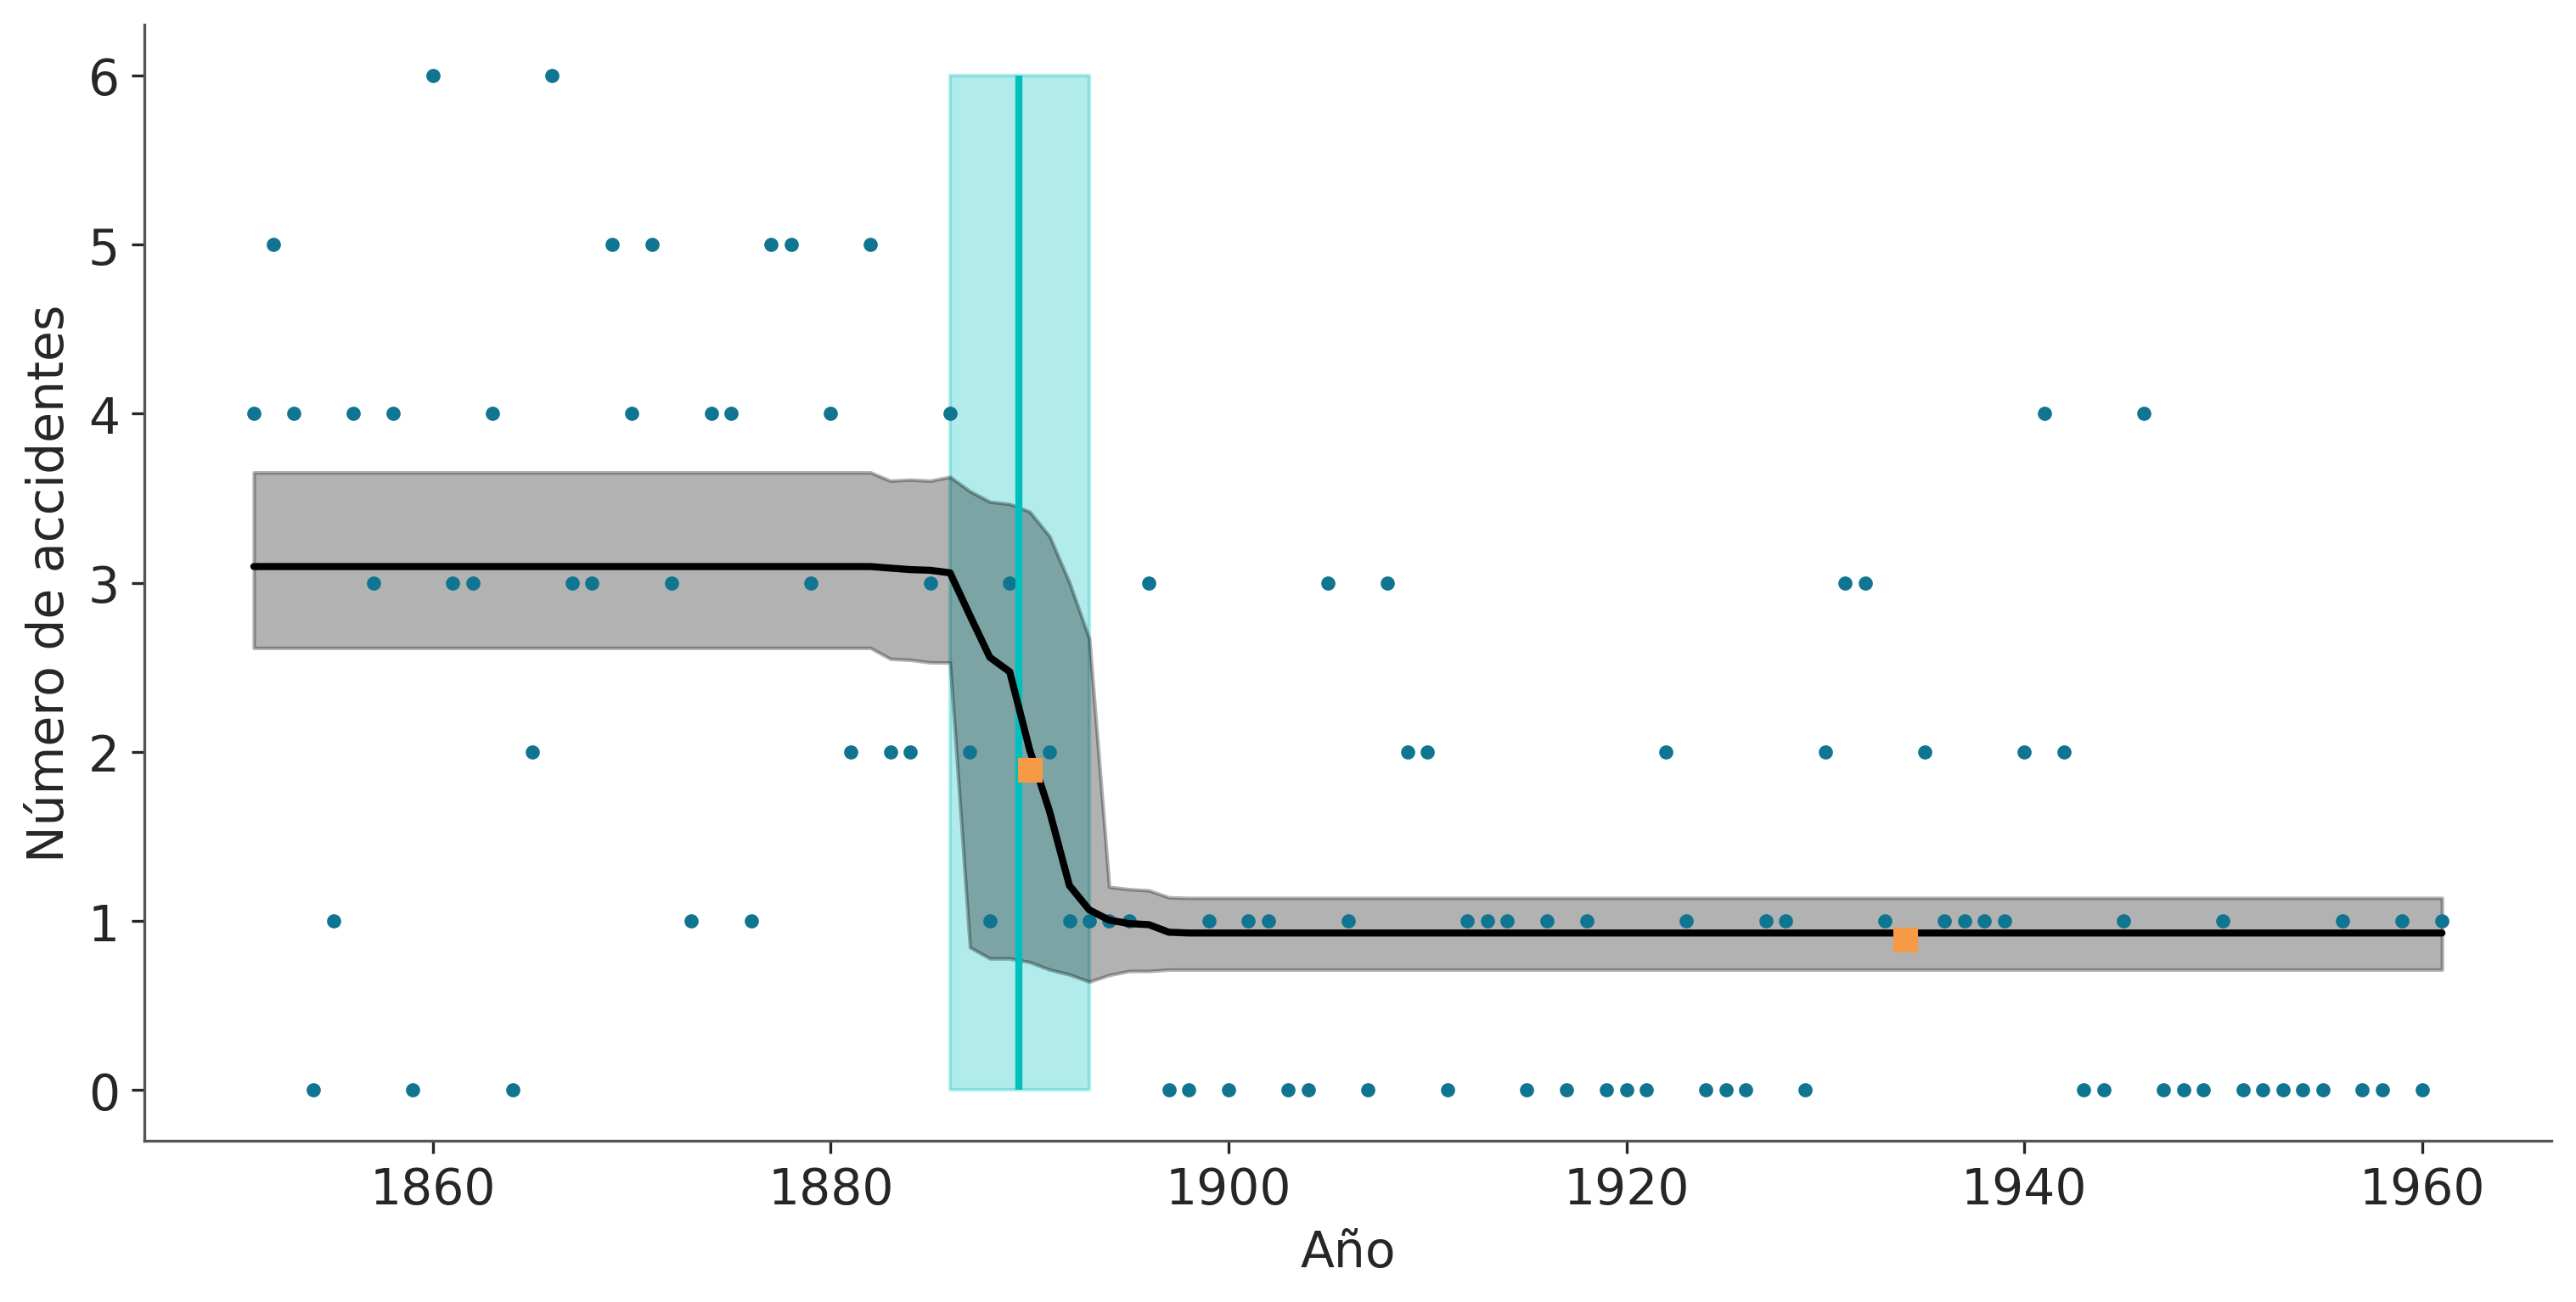

In [15]:
tasa_mean = idata_cat.posterior["tasa"].mean(("chain", "draw"))
tasa_hdi = az.hdi(idata_cat.posterior["tasa"].values)
pc_hdi = az.hdi(idata_cat.posterior["pc"])["pc"]

_, ax = plt.subplots(figsize=(10, 5), sharey=True)
ax.plot(años, accidentes, ".")

ax.set_ylabel("Número de accidentes")
ax.set_xlabel("Año")

ax.vlines(
    idata_cat.posterior["pc"].mean(("chain", "draw")),
    accidentes.min(),
    accidentes.max(),
    color="C1",
    lw=2,
)


ax.fill_betweenx(
    [accidentes.min(), accidentes.max()], pc_hdi[0], pc_hdi[1], alpha=0.3, color="C1"
)
ax.plot(años, tasa_mean, "k", lw=2)
ax.fill_between(años, tasa_hdi[:, 0], tasa_hdi[:, 1], alpha=0.3, color="k")


faltante0 = (
    idata_cat.posterior["acc_unobserved"].sel(acc_unobserved_dim_0=0).mean(("chain", "draw"))
)
faltante1 = (
    idata_cat.posterior["acc_unobserved"].sel(acc_unobserved_dim_0=1).mean(("chain", "draw"))
)

ax.plot(años[np.isnan(accidentes)], [faltante0, faltante1], "C2s");

## Comparando grupos

Una tarea común al analizar datos es comparar grupos. Podríamos estar interesados en analizar los resultados de un ensayo clínico donde se busca medir la efectividad de una droga, o la reducción de la cantidad de accidentes de tránsito al introducir un cambio en las regulaciones de tránsito, o el desempeño de estudiantes bajo diferentes aproximaciones pedagógicas, etc. Este tipo de preguntas se suele resolver en el marco de lo que se conoce como pruebas de hipótesis que busca declarar si una observación es estadísticamente significativa o no. Nosotros tomaremos una ruta alternativa. 

Al comparar grupos debemos decidir que característica(s) vamos a usar. Una característica común es la media de cada grupo. En ese caso podemos calcular la distribución _a posteriori_ de la diferencia entre medias. Para ayudarnos a entender este posterior usaremos 3 herramientas:


* Un _posteriorplot_ con un valor de referencia
* Una medida llamada _d de Cohen_ 
* La probabilidad de superioridad

En el capítulo anterior ya vimos un ejemplo de cómo usar _posteriorplot_ con un valor de referencia, pronto veremos otro ejemplo. Las novedades aquí son el d de Cohen y la probabilidad de superioridad, dos maneras populares de expresar el tamaño del efecto.

### d de Cohen

Una medida muy común, al menos en ciertas disciplinas, para cuantificar el tamaño del efecto es el d de Cohen

$$
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_2^2 + \sigma_1^2}{2}}}
$$


De acuerdo con esta expresión, el tamaño del efecto es la diferencia de las medias con respecto a la desviación estándar combinada de ambos grupos. Ya que es posible obtener una distribución _a posteriori_ de medias y de desviaciones estándar, también es posible calcular una distribución _a posteriori_ de los valores d de Cohen. Por supuesto, si sólo necesitamos o queremos una estimación puntual, podríamos calcular la media de esa distribución _a posteriori_. En general, al calcular una desviación estándar combinada, se toma en cuenta el tamaño de la muestra de cada grupo explícitamente, pero la ecuación de _d de Cohen_ omite el tamaño de la muestra, la razón es que tomamos estos valores del _posterior_ (por lo que ya estamos considerando la incertidumbre de las desviaciones estándar).

> Un d de Cohen es una forma de medir el tamaño del efecto donde la diferencia de las medias se estandariza al considerar las desviaciones estándar de ambos grupos.

Cohen introduce la variabilidad de cada grupo al usar sus desviaciones estándar. Esto es realmente importante, una diferencia de 1 cuando la desviación estándar es de 0.1 es muy grande en comparación con la misma diferencia cuando la desviación estándar es 10. Además, un cambio de x unidades de un grupo respecto del otro podría explicarse por cada punto _desplazándose_ exactamente x unidades o la mitad de los puntos sin cambiar mientras la otra mitad cambia 2x unidades, y así con otras combinaciones. Por lo tanto, incluir las variaciones intrínsecas de los grupos es una forma de poner las diferencias en contexto. Re-escalar (estandarizar) las diferencias nos ayuda a dar sentido a la diferencia entre grupos y facilita evaluar si el cambio es importante, incluso cuando no estamos muy familiarizados con la escala utilizada para las mediciones.

Un d de Cohen se puede interpretar como un Z-score. Un Z-score es la cantidad de desviaciones estándar que un valor difiere del valor medio de lo que se está observando o midiendo, puede ser positivo o negativo dependiendo de si la diferencia es por exceso o por defecto. Por lo tanto, un d de Cohen de -1.2, indica que la media de un grupo está 1.2 desviación estándar por debajo de la media del otro grupo.


Incluso con las diferencias de medias estandarizadas, puede ser necesario tener que _calibrarnos_ en función del contexto de un problema determinado para poder decir si un valor de d de Cohen es _grande_, _pequeño_, _mediano_, _importante_, _despreciable_, etc. Afortunadamente, esta calibración se puede adquirir con la práctica, a modo de ejemplo si estamos acostumbrados a realizar varios análisis para más o menos el mismo tipo de problemas, podemos acostumbrarnos a un d de Cohen de entre 0.8 y 1.2, de modo que si obtenemos un valor de 2 podría ser que estamos frente a algo importante, inusual (¡o un error!). Una alternativa es consultar con expertos en el tema. 

Una muy buena página web para explorar cómo se ven los diferentes valores de Cohen's es http://rpsychologist.com/d3/cohend. En esa página, también encontrarán  otras formas de expresar el tamaño del efecto; algunas de ellos podrían ser más intuitivas, como la probabilidad de superioridad que analizaremos a continuación.


### Probabilidad de superioridad


Esta es otra forma de informar el tamaño del efecto y se define como la probabilidad que un dato tomado al azar de un grupo tenga un valor mayor que un punto tomado al azar del otro grupo. Si suponemos que los datos que estamos utilizando se distribuyen de forma Gaussiana, podemos calcular la probabilidad de superioridad a partir de la d de Cohen usando la expresión:

\begin{equation} \label{eq_ps}
ps = \Phi \left ( \frac{\delta}{\sqrt{2}} \right)
\end{equation}


Donde $\Phi$ es la distribución normal acumulada y $\delta$ es el d de Cohen. Podemos calcular una estimación puntual de la probabilidad de superioridad (lo que generalmente se informa) o podemos calcular la distribución _a posteriori_. Si no estamos de acuerdo con la suposición de normalidad, podemos descartar esta fórmula y calcularla directamente a partir del _posterior_ sin necesidad de asumir ninguna distribución. Esta es una de las ventajas de usar métodos de muestreo para estimar el _a posteriori_, una vez obtenidas las muestras lo que podemos hacer con ellas es muy flexible.

### El conjunto de datos _propinas_


Para explorar el tema de esta sección, vamos a usar el conjunto de datos tips (propinas). Estos datos fueron informados por primera vez por Bryant, P. G. and Smith, M (1995) _Practical Data Analysis: Case Studies in Business Statistics_.

Queremos estudiar el efecto del día de la semana sobre la cantidad de propinas en un restaurante. Para este ejemplo, los diferentes grupos son los días. Comencemos el análisis cargando el conjunto de datos como un DataFrame de Pandas usando solo una línea de código. Si no está familiarizado con Pandas, el comando _tail_ se usa para mostrar las últimas filas de un DataFrame:

In [16]:
tips = pd.read_csv("datos/propinas.csv")
tips.tail()

,total_cuenta,propina,genero,fumador,dia,tiempo,cantidad
239,29.03,5.92,Hombre,No,Sab,Cena,3
240,27.18,2.00,Mujer,Si,Sab,Cena,2
241,22.67,2.00,Hombre,Si,Sab,Cena,2
242,17.82,1.75,Hombre,No,Sab,Cena,2
243,18.78,3.00,Mujer,No,Jue,Cena,2


Para este ejemplo solo vamos a usar las columnas `dia` y `propina` y vamos a usar la función `plot_forest` de ArviZ. Aún cuando ArviZ está pensado para análisis de modelos Bayesianos algunos de sus funciones pueden ser útiles para analizar datos.

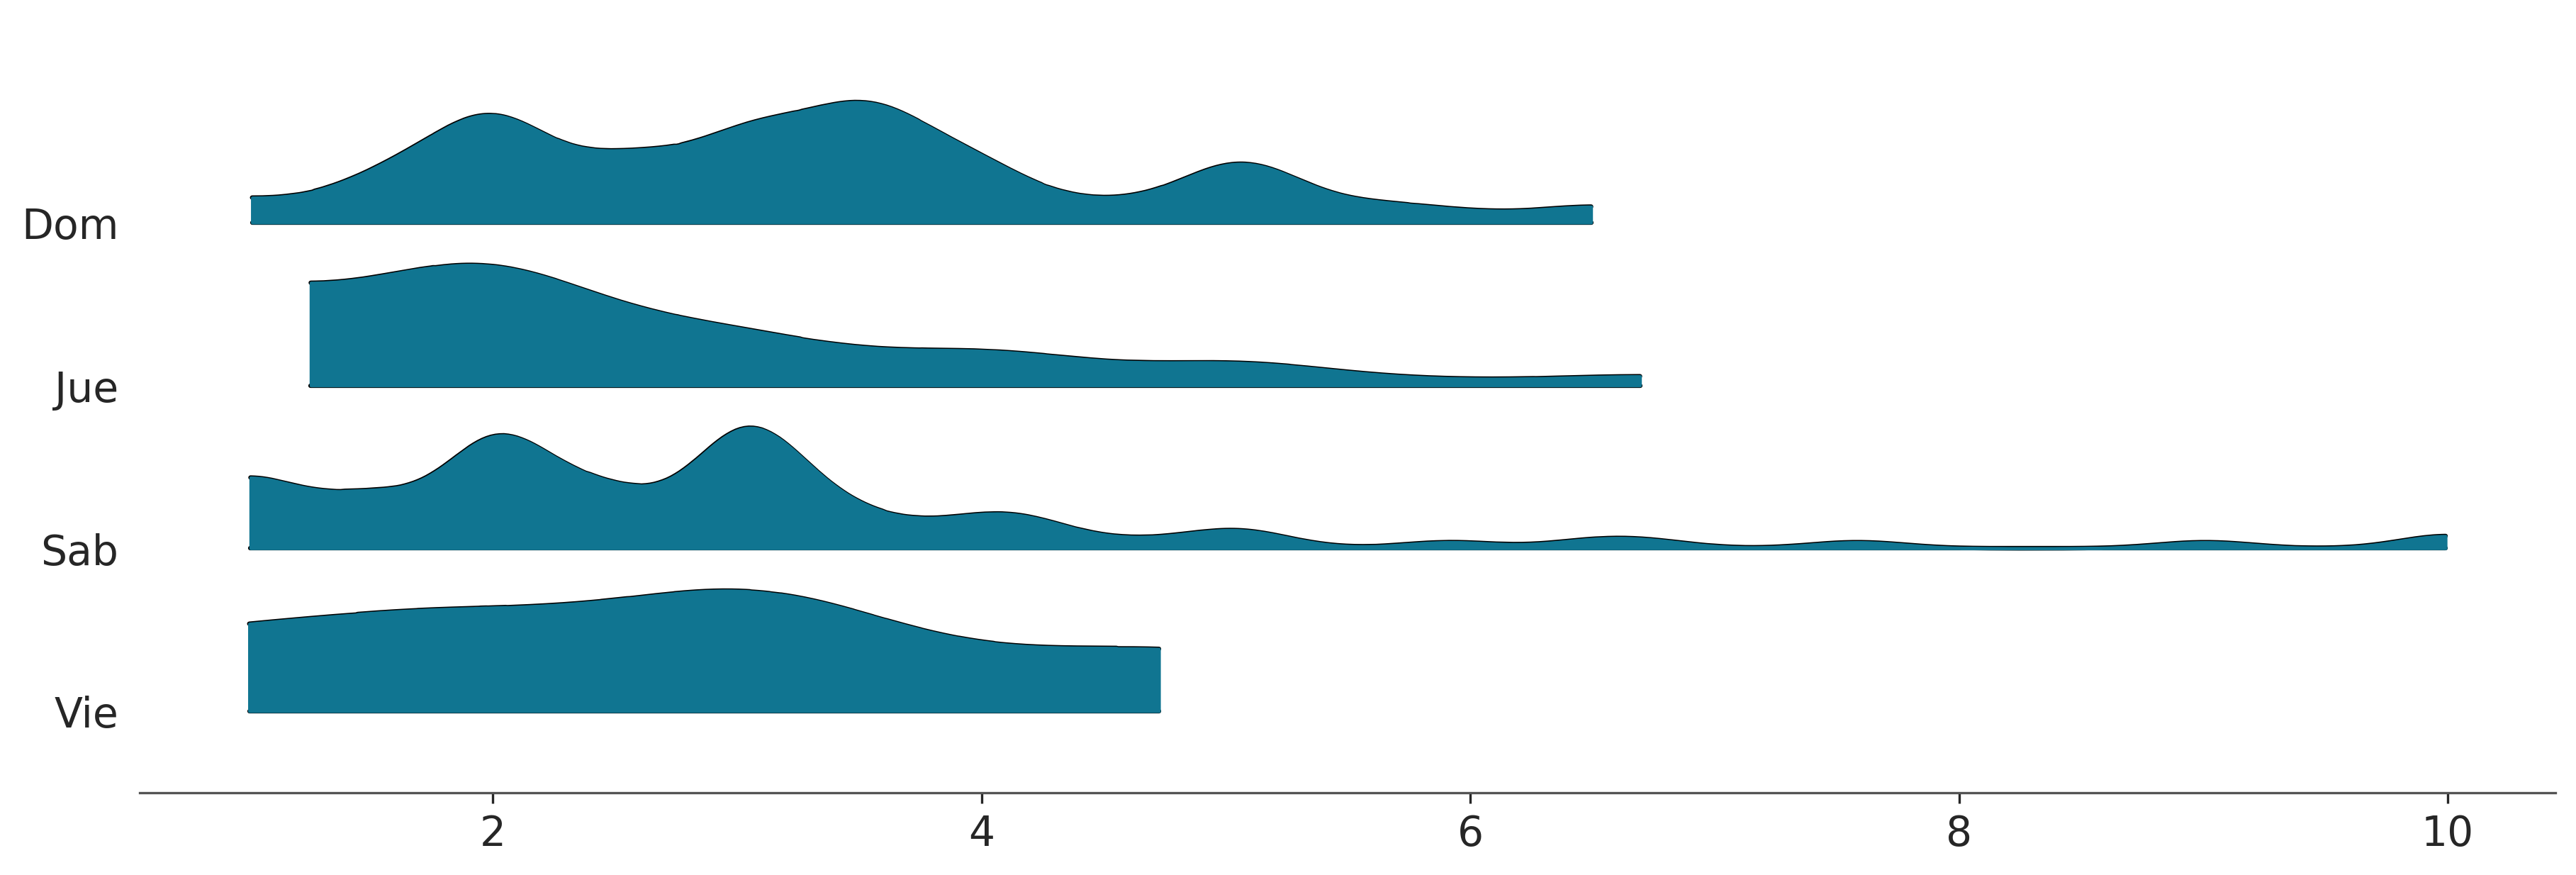

In [17]:
az.plot_forest(
    tips.pivot(columns="dia", values="propina").to_dict("list"),
    kind="ridgeplot",
    hdi_prob=1,
    figsize=(12, 4),
)

A fin de simplificar el análisis vamos a crear 2 variables:
* La variable `categories` contiene los nombres de los días (abreviados)
* La variable `idx` codifica los días de la semana como enteros entre 0 y  3.

In [18]:
categories = np.array(["Jue", "Vie", "Sab", "Dom"])

tip = tips["propina"].values
idx = pd.Categorical(tips["dia"], categories=categories).codes

Para este modelo necesitamos definir 4 grupos, uno por cada dia. Supongamos que cada grupo lo queremos representar como una distribución Gamma con media $\mu$ y desviación estándar $\sigma$. En ese caso vamos a necesitar definir 4 medias y 4 desviaciones estándar. Una versión `naive` sería escribir 8 distribuciones a priori. Algo como esto:

```python
with pm.Model() as comparación_grupos:
    μ0 = pm.Normal('μ0', mu=0, sigma=5)
    μ1 = pm.Normal('μ1', mu=0, sigma=5)
    μ2 = pm.Normal('μ2', mu=0, sigma=5)
    μ3 = pm.Normal('μ3', mu=0, sigma=5)
    σ0 = pm.HalfNormal('σ0', sigma=1)
    σ1 = pm.HalfNormal('σ1', sigma=1)
    σ2 = pm.HalfNormal('σ2', sigma=1)
    σ3 = pm.HalfNormal('σ3', sigma=1)
    
    ....
```

Esto es sintáticamennte posible y semánticamente correcto (es lo que hicimos en el modelo de los accidentes mineros). Pero repetir código es en generl una muy mala práctica que dificulta la lectura del código/modelo y dificulta hacer cambios a futuro. Una forma de no repetir código es escribir `for loops`. Pero en PyMC (como en NumPy y otras librerías de Python) lo que conviene es vectorizar el código. Para ello podemos especificar el argumento `shape` para los priors $\mu$ y $\sigma$. El modelo completo nos quedaría de la siguiente manera:

```python
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sigma=5, shape=4)
    σ = pm.HalfNormal('σ', sigma=1, shape=4)
    
    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip)
```

Es importante notar que estamos especificando 4 valores independiente de $\mu$ y cuatro valores independientes de $\sigma$ y que $\mu$ y $\sigma$ son vectores de dimensión 4.Fijensé que para el likelihood usamos la variable `idx` para indexar de forma adecuada $\mu$ y $\sigma$ para asegurar que usamos los parámetros correctos para cada grupo. 

Usar shapes es correcto, pero PyMC provee una sintaxis alternativa que a veces es más conveniente. Esta sintaxis consiste en especificar coordenadas y dimensiones. La ventaja de esto es que permite una mejor integración con ArviZ. Veamos, en este ejemplo tenemos 4 valores para las medias y 4 para las desviaciones estándar, y por eso usamos `shape=4`. El InferenceData tendrá 4 indices `0, 1, 2, 3` correspondientes a cada uno de los 4 días. Pero es trabajo del usuario asociar esos indices numéricos con los días. En cambio al usar coordenadas y dimensiones nosotros podremos usar los rótulos `'Jue', 'Vie', 'Sab', 'Dom'` para referirnos a los parámetros relacionados con cada uno de estos días. ArviZ también podrá hacer uso de estos rótulos. Referirse a "rotulos" y no a indices, suele ser más simple y contribuye a evitar errores.

Vamos a especificar dos coordenadas `dias` con las dimensiones `'Jue', 'Vie', 'Sab', 'Dom'` y `dias_flat` que contendrá los mismo rótulos pero repetidos según el orden y longitud que corresponda con cada observación. Esto último será útil para poder obtener pruebas predictivas a posteriori para cada día.

In [19]:
coords = {"dias": categories, "dias_flat": categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal("μ", sigma=5, dims="dias")
    σ = pm.HalfNormal("σ", sigma=1, dims="dias")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="dias_flat")

    idata_cg = pm.sample()
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1332 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

Una vez obtenido un  _a posteriori_ podemos hacer todos los análisis que creamos pertinentes con el. Primero hagamos una prueba predictiva a posteriori. Vemos que en general somos capaces de capturar la forma general de las distribuciones, pero hay detalles que se nos escapan. Esto puede deberse al tamaño relativamente pequeño de la muestra, a que hay otros factores además del día que tienen influencia en las propinas o una combinación de ambas. Por ahora seguiremos con el análisis considerando que el modelo es lo suficientemente bueno 

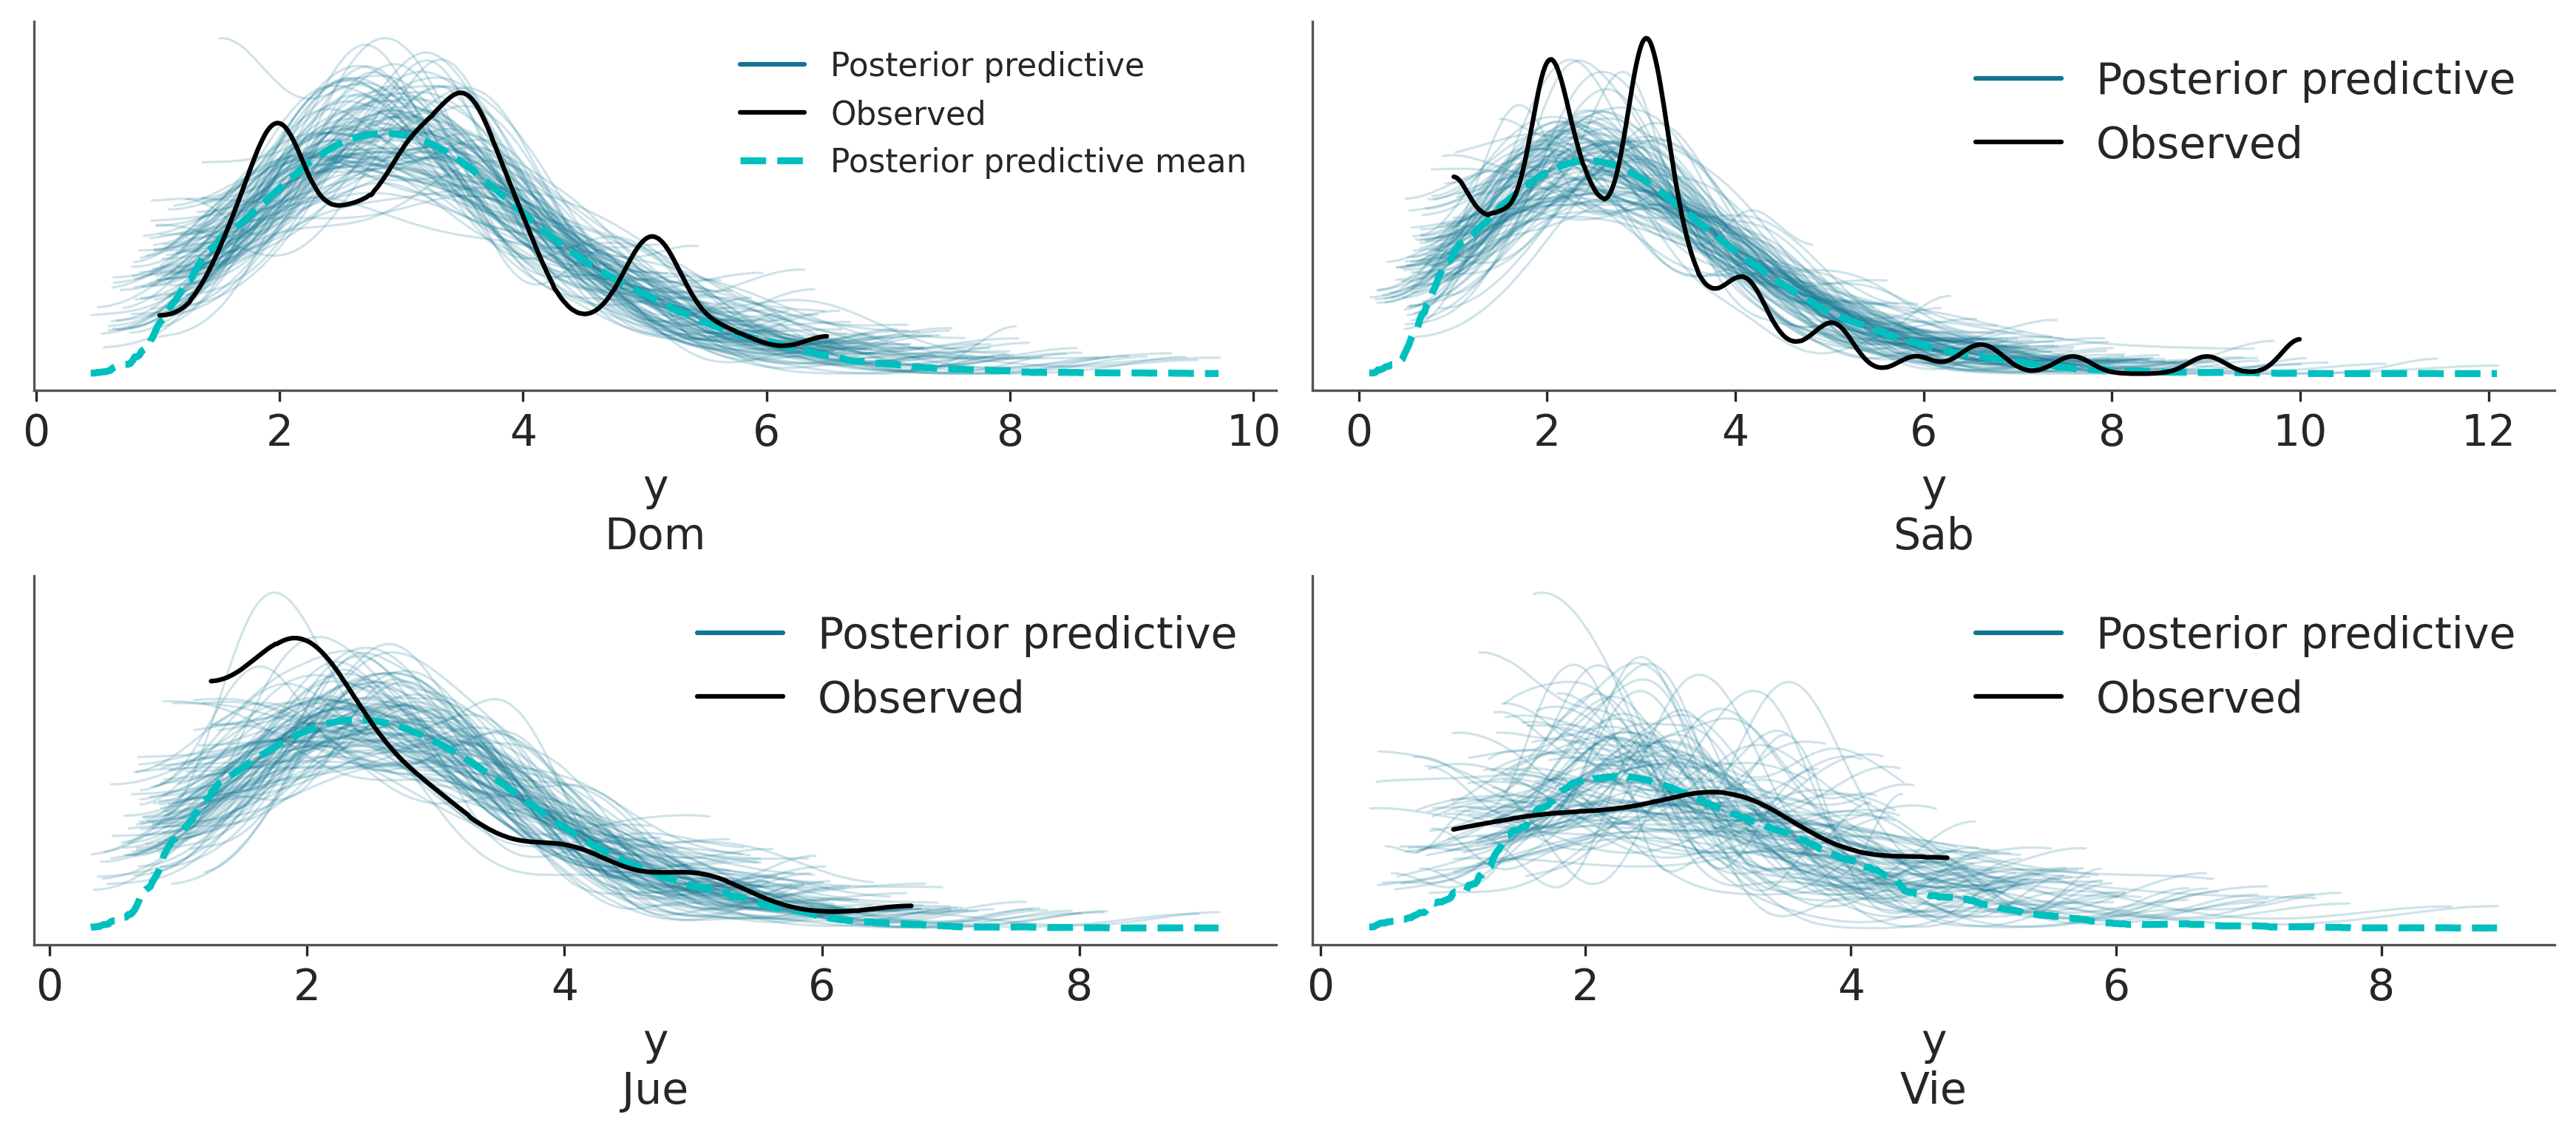

In [20]:
_, axes = plt.subplots(2, 2)
az.plot_ppc(
    idata_cg,
    num_pp_samples=100,
    coords={"dias_flat": [categories]},
    flatten=[],
    ax=axes,
);

Podemos ver la distribución de cada uno de los parámetros haciendo

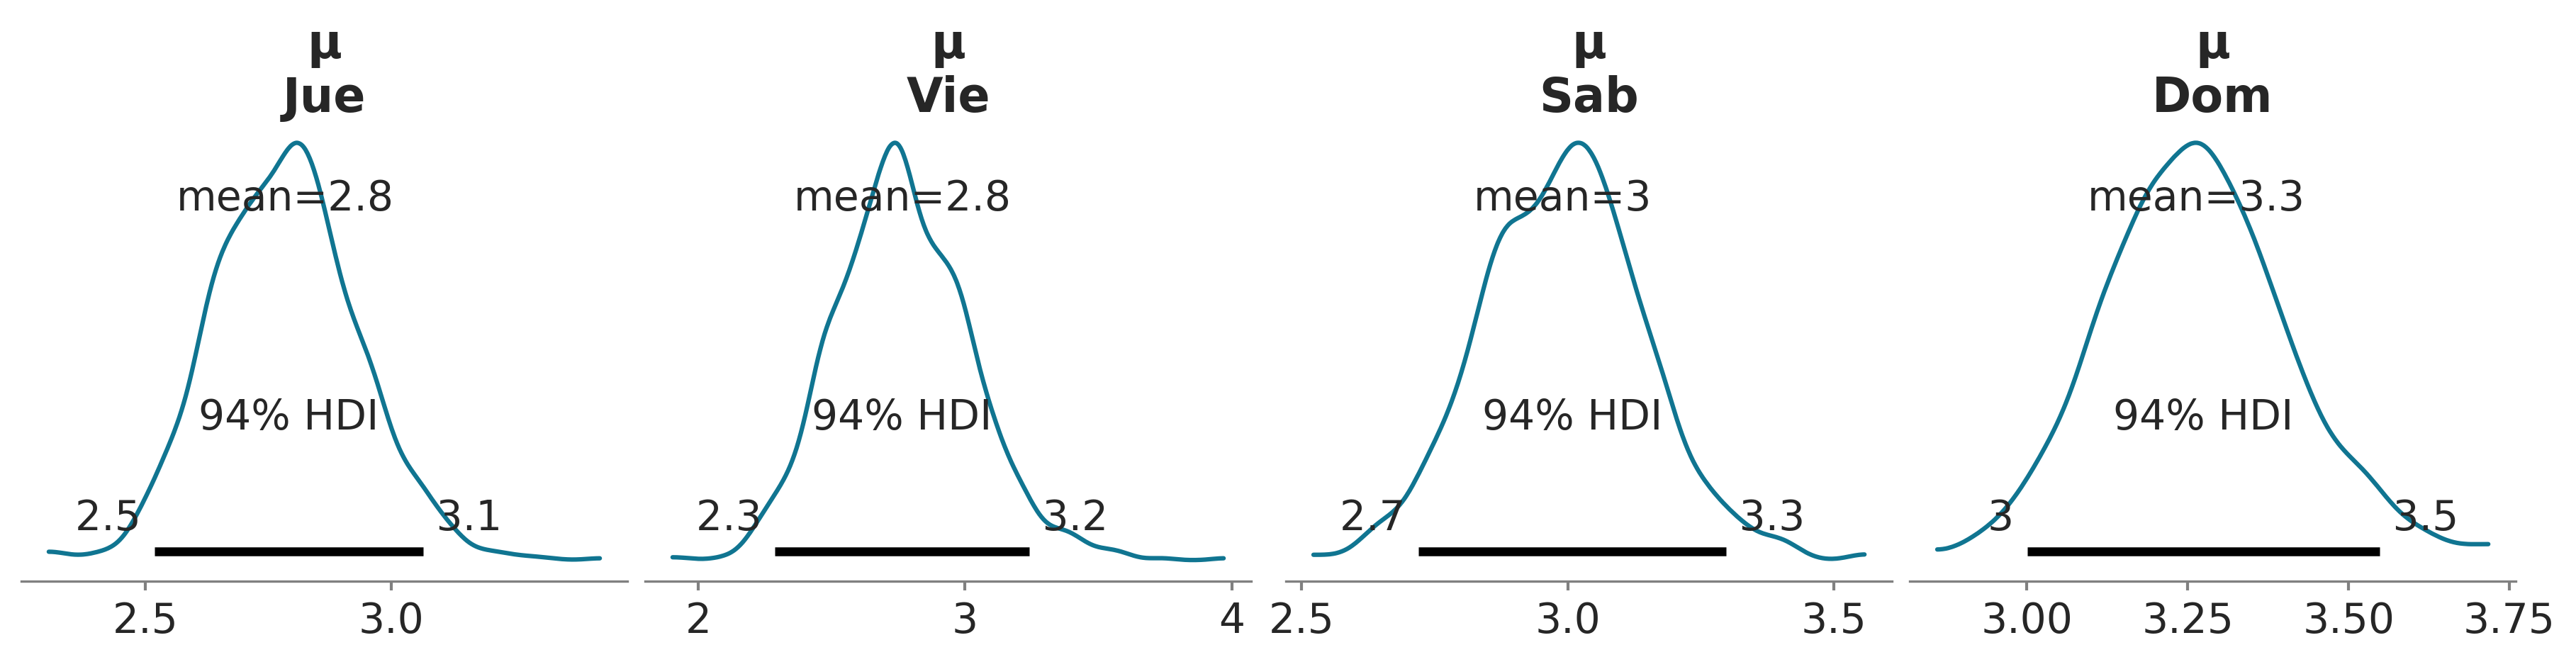

In [21]:
az.plot_posterior(idata_cg, var_names="μ", figsize=(12, 3));

La figura anterior es bastante informativa, por ejemplo vemos que los valores medios de las propinas difieren en solo unos pocos centavos y que para los domingos el valor es ligeramente más alto que para el resto de los días analizados. 

Pero quizá consideramos que puede ser mejor mostrar los datos de otra forma. Por ejemplo podemos calcular todas las diferencias de medias _a posteriori_ entre si. Además podríamos querer usar alguna medida del tamaño del efecto que sea popular entre nuestra audiencia, como podrían ser la _probabilidad de superioridad_ o _d de Cohen_.


**Cohen's d**

$$
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}}
$$


* Se puede interpretar como un *z-score*. Cuántas desviaciones estándar una media de un grupo está por encima (o por debajo) de la media del otro grupo
* [Ejemplo interactivo](http://rpsychologist.com/d3/cohend)

**Probabilidad de superioridad**

* La probabilidad que un dato tomado de un grupo sea mayor que la de un dato tomado del otro grupo.
* Si suponemos que los datos se distribuyen normalmente, entonces:


$$
\text{ps} = \Phi \left ( \frac{\delta}{\sqrt{2}} \right)
$$


$\Phi$ es la `cdf` de una distribución normal $\delta$ es el valor del d de Cohen.


Con el siguiente código usamos `plot_posterior` para graficar todas las diferencias no triviales o redundantes. Es decir evitamos las diferencias de un día con sigo mismo y evitamos calcular 'Vie - Jue' si ya hemos calculado  'Jue - Vie'. Si lo viéramos como una matriz de diferencias solo estaríamos calculando la porción triangular superior.

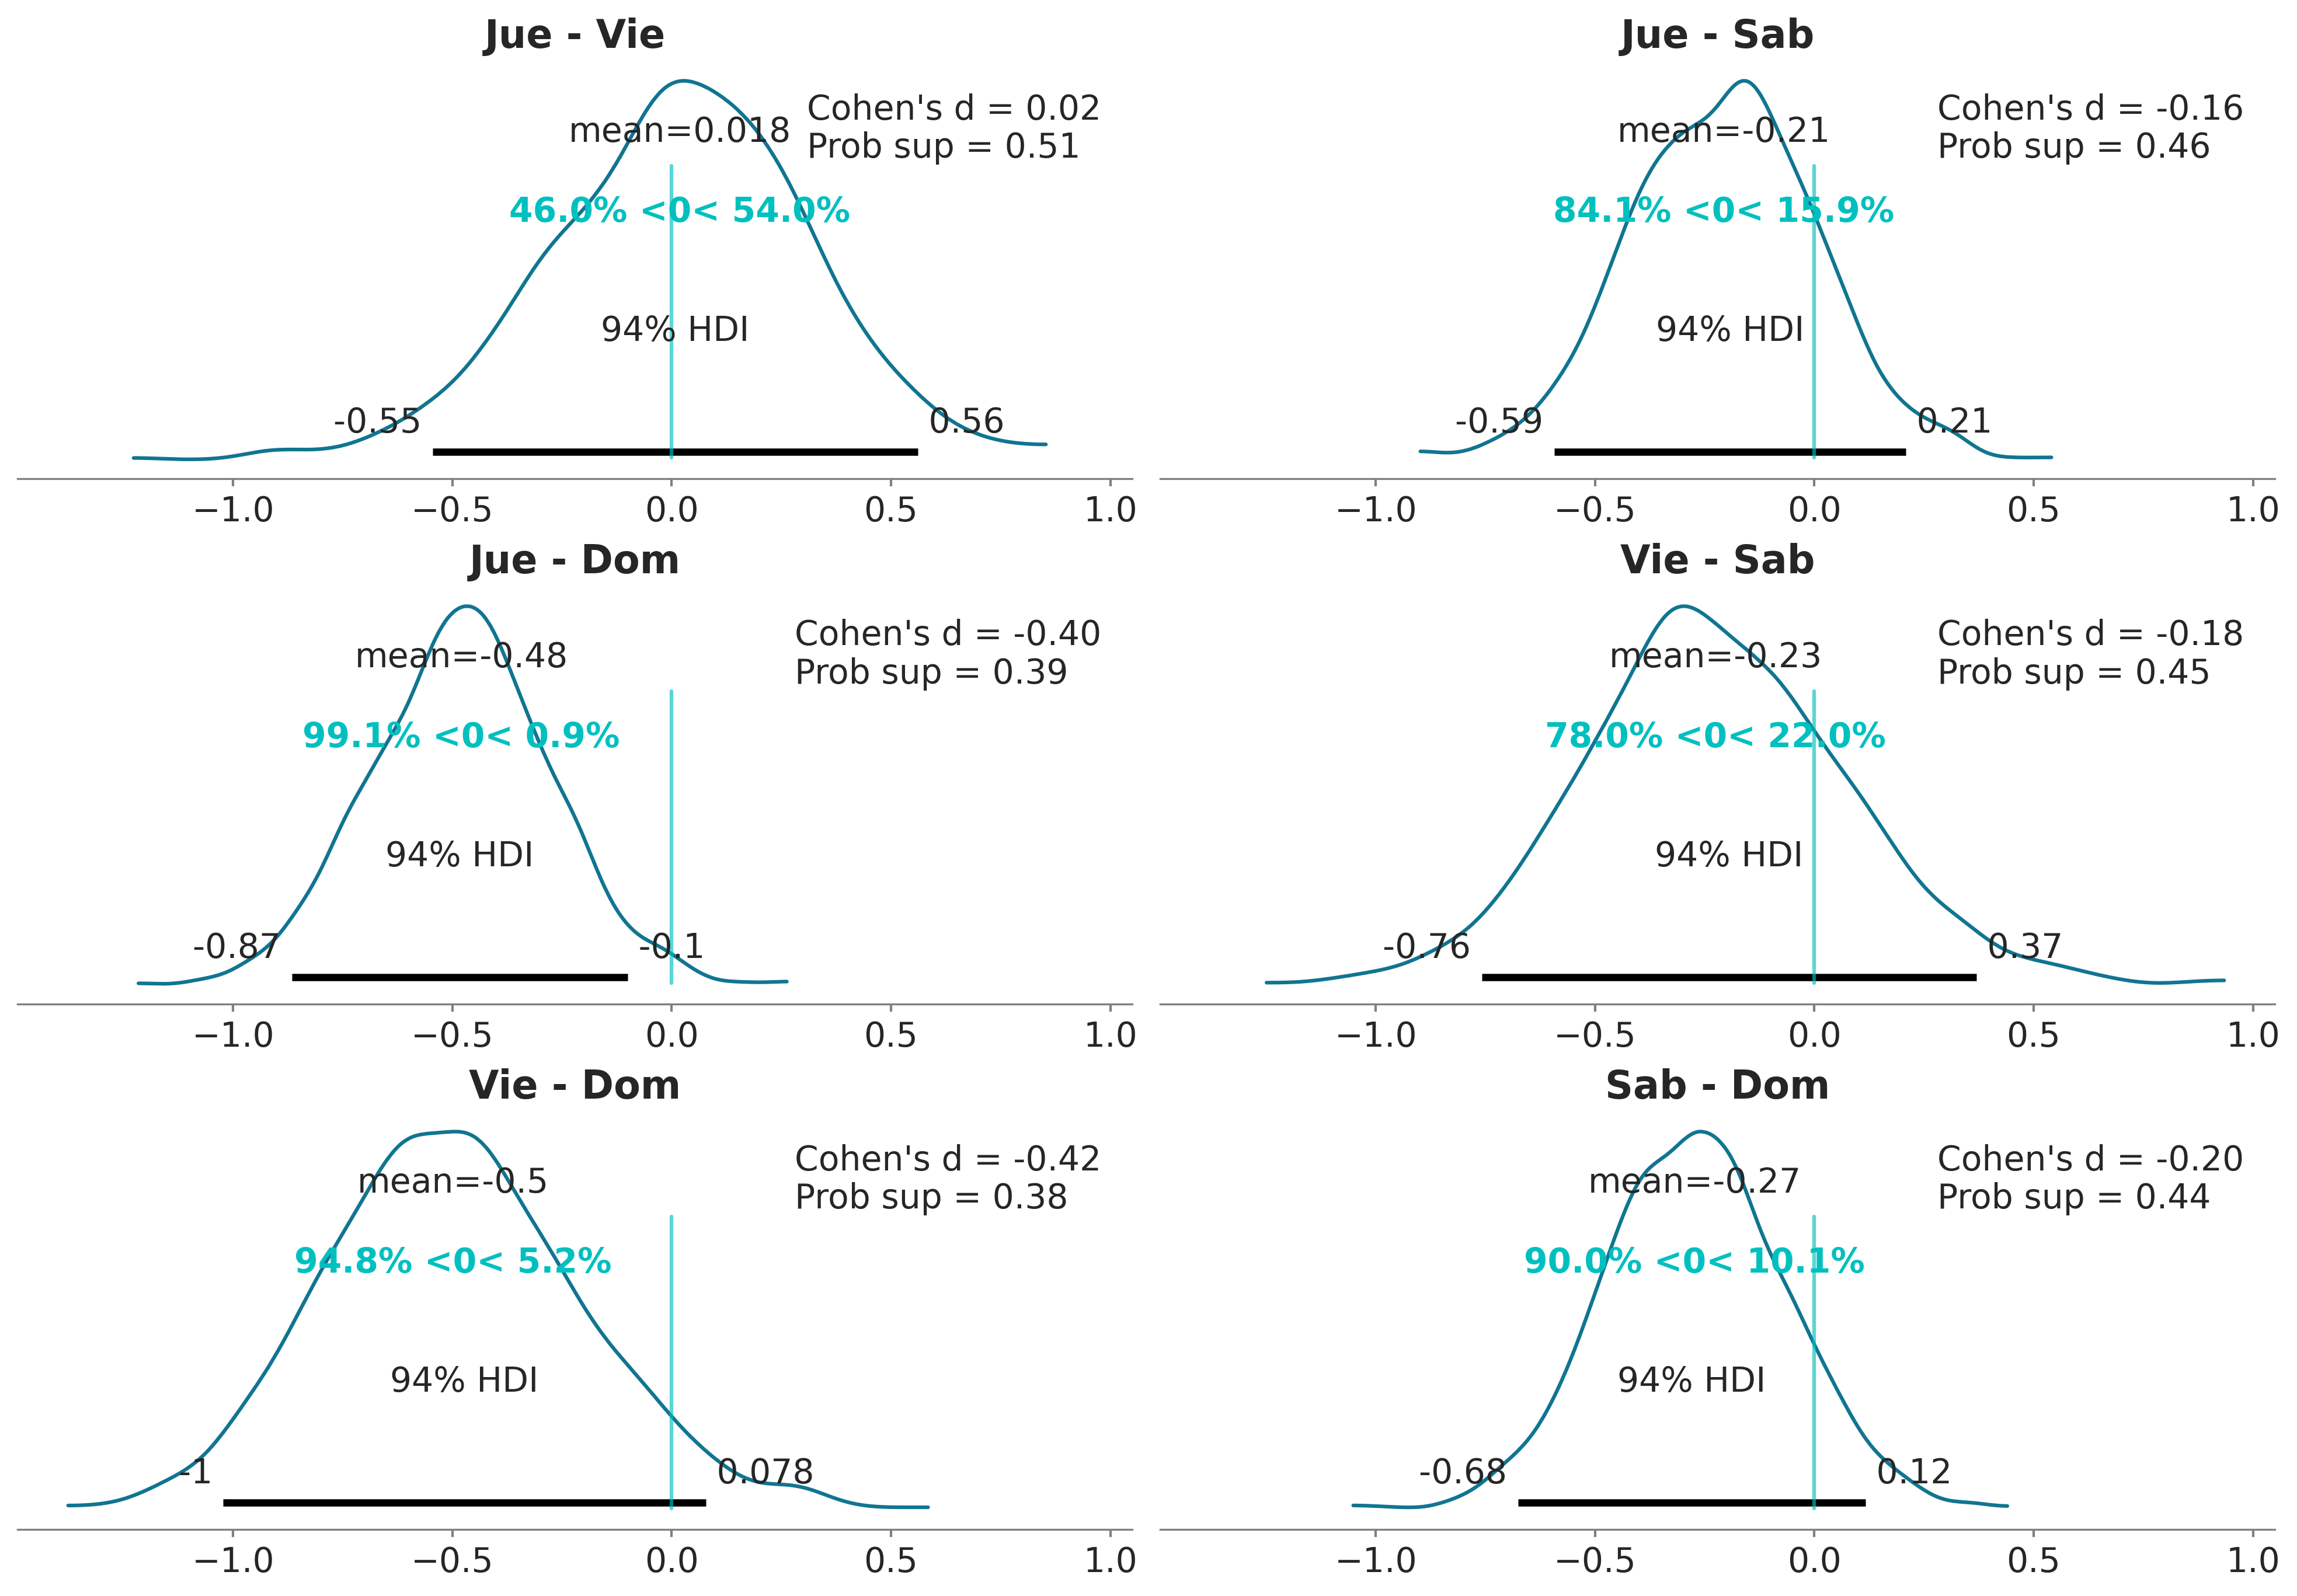

In [22]:
cg_posterior = az.extract(idata_cg)

dist = pz.Normal(0, 1)

comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]

_, axes = plt.subplots(3, 2, figsize=(13, 9), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["μ"].sel(dias=i) - cg_posterior['μ'].sel(dias=j)
    
    d_cohen = (means_diff /
               np.sqrt((cg_posterior["σ"].sel(dias=i)**2 + 
                        cg_posterior["σ"].sel(dias=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend(loc=1)

Una forma de interpretar estos resultados es comparando el valor de referencia con el intervalo HDI. De acuerdo con la figura anterior, tenemos solo un caso cuando el 94% HDI excluye el valor de referencia de cero, la diferencia en las propinas entre el jueves y el domingo. Para todos los demás ejemplos, no podemos descartar una diferencia de cero (de acuerdo con los criterios de superposición de valores de referencia de HDI). Pero incluso para ese caso, ¿es una diferencia promedio de ≈0.5 dólares lo suficientemente grande? ¿Es suficiente esa diferencia para aceptar trabajar el domingo y perder la oportunidad de pasar tiempo con familiares o amigos? ¿Es suficiente esa diferencia para justificar promediar las propinas durante los cuatro días y dar a cada mozo/a la misma cantidad de dinero de propina? Este tipo de preguntas es crucial para interpretar los datos y/o tomar decisiones, pero las respuestas no las puede ofrecer la estadística de forma automática (ni ningún otro procedimiento). La estadística solo pueden ayudar en la interpretación y/o toma de decisiones.

Nota: Dependiendo del público el gráfico anterior puede que esté demasiado "cargado", quizá es útil para una discusión dentro del equipo de trabajo, pero para un público en general quizá convenga sacar elementos o repartir la información entre una figura y una tabla o dos figuras.

## Resumen

Aunque la estadística Bayesiana es conceptualmente simple, los modelos probabilísticos a menudo conducen a expresiones analíticamente intratables. Durante muchos años, esta fue una gran barrera que obstaculizó la adopción amplia de métodos Bayesianos. Afortunadamente, la matemática, la física y la informática vinieron al rescate en forma de métodos numéricos capaces, al menos en principio, de resolver cualquier inferencia. La posibilidad de automatizar el proceso de inferencia ha llevado al desarrollo de los lenguajes de programación probabilista que permiten una clara separación entre la definición del modelo y la inferencia.

PyMC es una librería de Python para programación probabilística con una sintaxis simple, intuitiva y fácil de leer que también está muy cerca de la sintaxis estadística utilizada para describir modelos probabilísticos. En este capítulo introducimos PyMC revisando el problema de la moneda que vimos en el capítulo anterior. La diferencia es que no tuvimos que derivar analíticamente la distribución  _a posteriori_. Los modelos en PyMC se definen dentro de un bloque `with`; para agregar una distribución de probabilidad a un modelo, solo necesitamos escribir una línea de código. Las distribuciones se pueden combinar y se pueden usar como priors (variables no observadas) o likelihoods (variables observadas). En la sintaxis de PyMC la única diferencia entre ambas es que para esta última debemos pasar los datos usando el argumento `observed`. Si todo va bien las muestras generadas por PyMC serán representativas de la distribución _a posteriori_ y por lo tanto serán una representación de las consecuencias lógicas del modelo y los datos.

ArviZ es una librería que nos ayuda a explorar los modelos definidos por PyMC (u otras librerías como PyStan, TFP, BeanMachine, etc). Una forma de usar el posterior para ayudarnos a tomar decisiones es comparando la ROPE con el intervalo HDI.  

Finalizamos comparando medias entre grupos, una tarea común en análisis de datos. Si bien esto a veces se enmarca en el contexto de las pruebas de hipótesis, tomamos otra ruta y trabajamos este problema como una inferencia del tamaño del efecto.

## Ejercicios

1. Usando PyMC reproducí los resultados del primer capítulo para el problema de la moneda. Usar los 3 priors usados en ese capítulo Beta(1, 1), Beta(0.5, 0.5), Beta(20, 20).

1. Reemplazá la distribución Beta por una uniforme en el intervalo [0, 1] ¿Cómo cambia la velocidad del muestreo? ¿Y si usas un intervalo más ámplio, como [-3, 3]? 

1. Los modelos de PyMC tienen un método `.to_graphviz()` que se puede utilizar para visualizar el modelo (también existe la función `pm.model_to_graphviz()`. Use este método para visualizar `nuestro_primer_modelo`. Compare el resultado con el diagrama de Kruschke.

1. En el modelo `comparación_grupos` que dimensión y tamaño tiene `μ[idx]` y `σ[idx]`? Justifique.

1. La Gaussiana es una distribución _sin límites_ es decir es válida en el intervalo $(-\infty, \infty)$, en el modelo `comparación_grupos` usamos una Gama como likelihood, pero podríamos haber usado una Gaussiana? Cambiarías tu respuesta si las propinas tomaran valores alrededor de 100 dolares?
  
1. Calculá la probabilidad de superioridad directamente a partir de las muestras de la distribución _a posteriori_, es decir sin la expresión analítica. Cómo se comparan los resultados con los valores obtenidos analíticamente.

1. Aplicá al menos uno de los modelos vistos en este capítulo a datos propios o de tu interés.